In [3]:
# RUN Main import block and TODO list

# TODO: see how uri calculated the ridges

# TODO: Perform Histogram equalization - start with it
# TODO: 
# take integral from the Highest peak+-0.005 divide by integral of the entire graph 
# This will be the peakness measure for the PSD ==> The desired ridge index
# TODO:
# take integral from the Highest peak+-0.005 divide by integral of the entire graph - it's the peakness measure for the PSD
# must select a peak above a min threshold in order to ignore noisy frequency
# must ignore peaks above a certain threshold in order to detect meaningful frequency
# run the PSD in moving windows every 200 px (deduced from the below PSD pointing to a freq of 1/0.02=50-> times 4= 200px)
# and medianf the result of the windows
# TODO:
# Another alternative: (with Yariv)
# Run PSD column by column - get the phase, freq, peakness and reconstruct an artificial ridge slice
# from this - reconstruct a "clean" artificial ridge image

%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
import shutil
import glob
from scipy import ndimage
from scipy import signal
#import cv2

from PIL import Image, ImageDraw, ImageFont

import mahotas as mh
from mahotas import polygon
# import pymorph as pm

import networkx as nx

from scipy import ndimage as nd
import skimage.transform as transform
import skimage.morphology as mp
import skimage.io as sio
import scipy.misc as sm
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage import exposure
from skimage import data, img_as_float
from sklearn.metrics import precision_recall_fscore_support

from bisect import bisect_left
import math
import warnings
import csv
import tensorflow as tf
# Pandas is used for data manipulation
import pandas as pd

In [4]:
# Constants
X_START = 1000
X_END = 6000
Y_START = 800
Y_END = 4300
BG_2_OBJ_RATIO = 0.91
CUBE_SIZE = 250
EDGE_GAP = 50
# ROOT_FOLDER = "/home/il239838/files/"
ROOT_FOLDER = "/Users/il239838/Downloads/private/Thesis/Papyrus/PX303/files/"
LEARNING_RATE = 0.001
BATCHES = 800
BATCH_SIZE = 50
BREAK_VAL = 1000

In [16]:
# UTILS
def renameFragmentsFiles(path):
    for root, dirs, files in os.walk(path):
        for file_ in files:
            split = file_.split("_")
            fileSplit = split[0].split("-")
            newFileName = fileSplit[0] + fileSplit[1] + "_" + split[1] + "_" + split[2]

            os.rename(os.path.join(root, file_), 
                      os.path.join(root, newFileName))
    

def handle_match_row(df_row):
    rectanglesArr = eval(df_row["fragmentAndSideDrawRect"])
    
    mins = np.amin(rectanglesArr, 0)
    maxs = np.amax(rectanglesArr, 0)
    minsmaxs = [mins[0], mins[1], maxs[2], maxs[3]]
    minsmins = [mins[0], mins[1], mins[0], mins[1]]
    width = maxs[2] - mins[0]
    height = maxs[3] - mins[1]
    slate = np.zeros((width, height))

    for rect in rectanglesArr:
        rect_slide = np.zeros((width, height))
        rect_adjusted =  np.subtract(rect, minsmins)
        rect_slide[rect_adjusted[0]:rect_adjusted[2], rect_adjusted[1]:rect_adjusted[3]] = 1
        slate = slate + rect_slide

    # import pdb; pdb.set_trace()

    slate_max = np.amax(slate)
    max_indices = np.where(slate == slate_max)
    # FIXME: need to fix next line as the square might be a jigsaw - need to pick the overall min and max indices
    voted_square = [max_indices[0][0], max_indices[1][0], max_indices[0][-1]+1, max_indices[1][-1]+1]
    adjusted_vote = np.add(minsmins,voted_square)
    mid_point = [(adjusted_vote[0] + adjusted_vote[2])/2, (adjusted_vote[1] + adjusted_vote[3])/2]

    firstImg = Image.open(ROOT_FOLDER+"fragments/"+df_row["firstFileName"]+".jpg")
    secondImg = Image.open(ROOT_FOLDER+"fragments/"+df_row["secondFileName"]+".jpg")
    
    con_width = firstImg.size[0] + secondImg.size[0]
    con_height = 0
    first_offset = np.abs(adjusted_vote[1])
    second_offset = int(np.abs(adjusted_vote[1] - mid_point[1]))
    if mid_point[1] <= 0:
        con_height = np.maximum(firstImg.size[1] + np.abs(adjusted_vote[1]), secondImg.size[1])
    else:
        con_height = np.maximum(secondImg.size[1] + np.abs(adjusted_vote[3]), firstImg.size[1])
    
    conImage = Image.new('RGBA', (con_width, con_height))
    conImage.paste(firstImg, (0, first_offset))
    conImage.paste(secondImg, (firstImg.size[0]+1, second_offset))

    # import pdb; pdb.set_trace()

    draw = ImageDraw.Draw(conImage)
    draw.rectangle(adjusted_vote.tolist(), fill="red", outline="red")
    conImage.save(ROOT_FOLDER+"squares/"+df_row["firstFileName"]+"_"+df_row["secondFileName"]+".jpg")
    
    
def draw_histogram_for_row(df_row, bins):
    matchPointArr = eval(df_row["fragmentAndSideMatchPoint"])
    vals = [row[1] for row in matchPointArr]
    plt.hist(vals, bins, facecolor='green')
    plt.show()
    # import pdb; pdb.set_trace()


In [6]:
# RUN ONCE ONLY!!!
#renameFragmentsFiles(ROOT_FOLDER+"fragments/");

In [ ]:
# EITHER RUN THIS: CREATE CUBES WITH VOTES
all_matches = pd.read_csv('votes_cubes_match_synt.csv') #('real_cubes_all_vote.csv')
all_matches = all_matches[all_matches["class"] == 1]
for idx, row in all_matches.iterrows():
    handle_match_row(row)


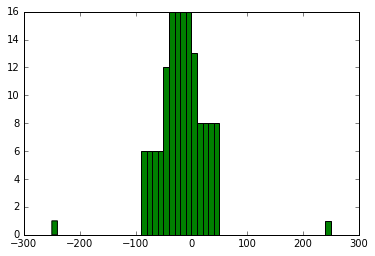

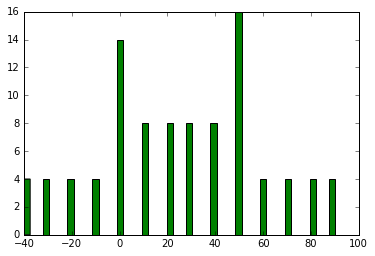

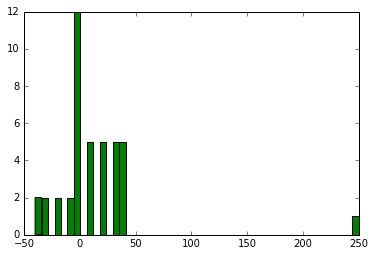

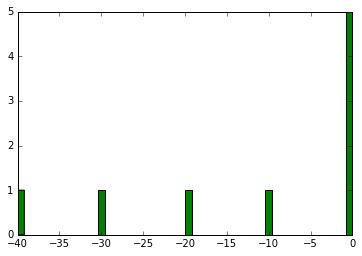

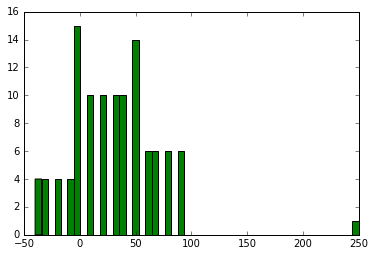

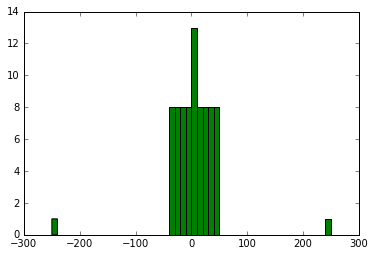

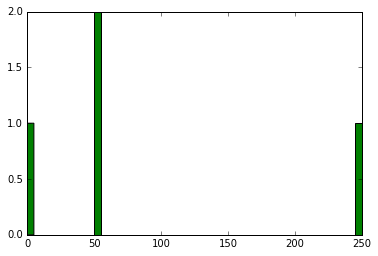

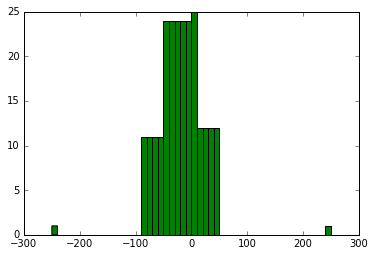

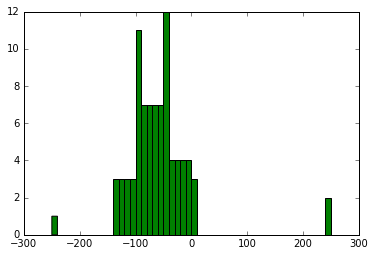

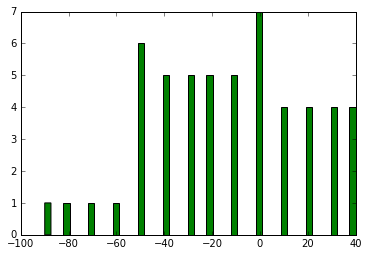

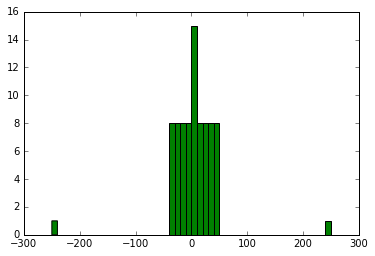

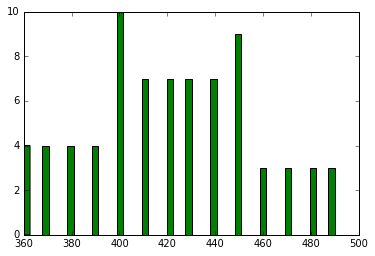

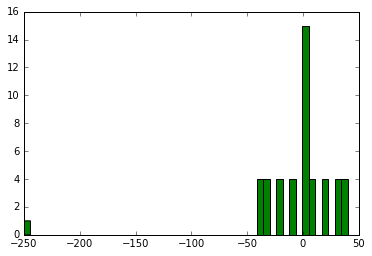

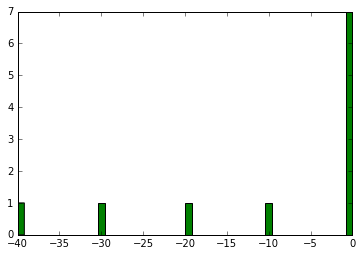

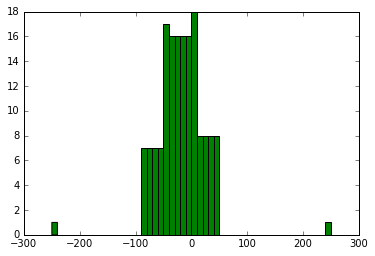

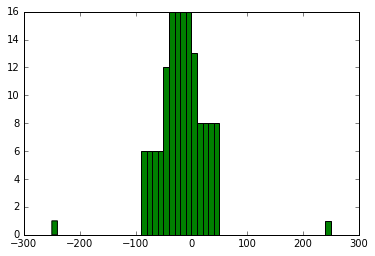

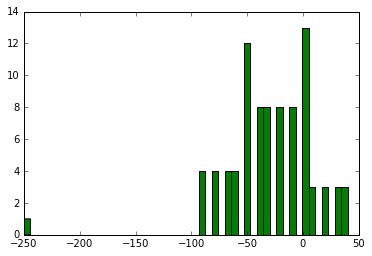

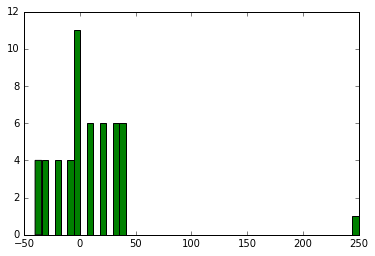

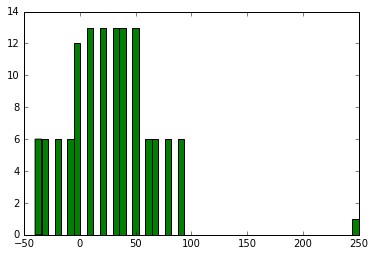

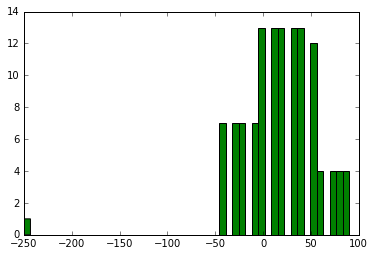

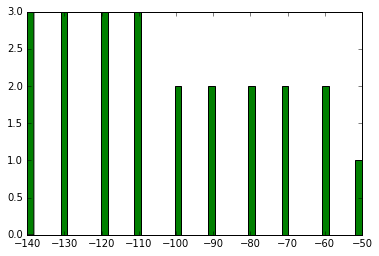

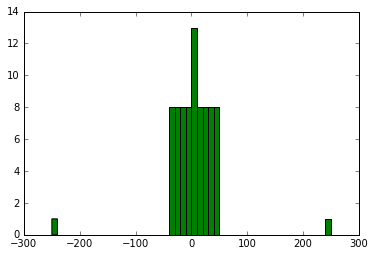

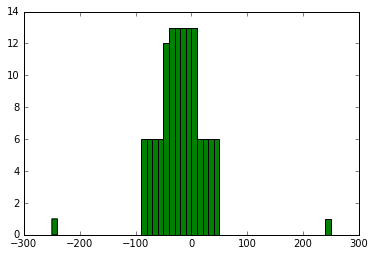

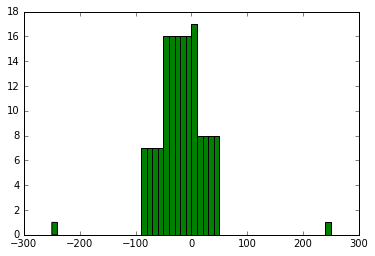

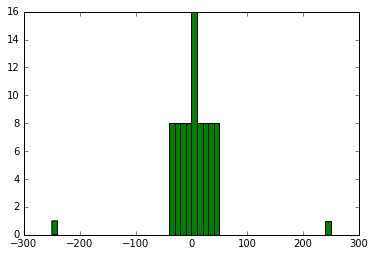

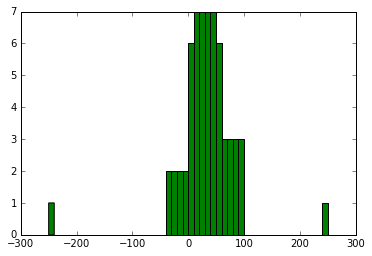

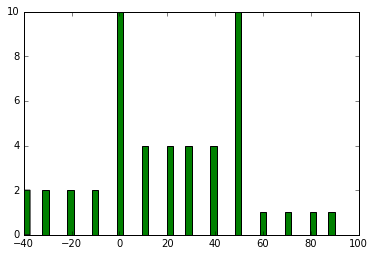

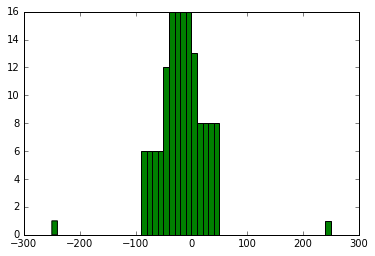

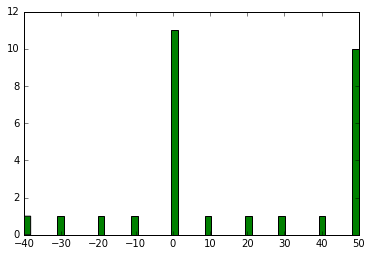

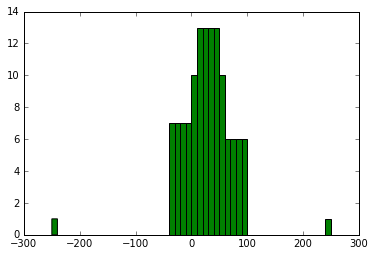

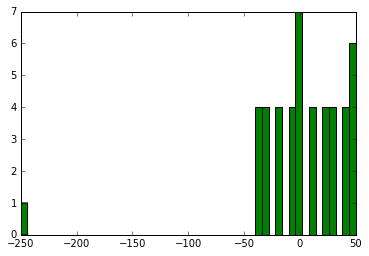

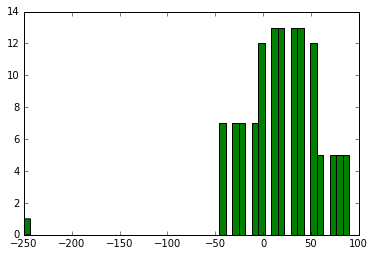

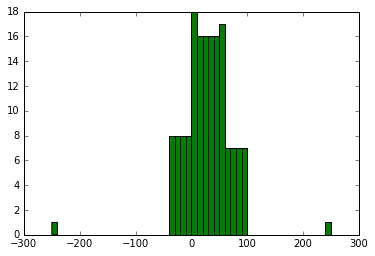

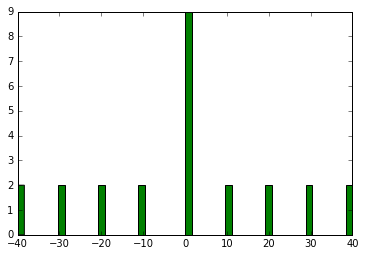

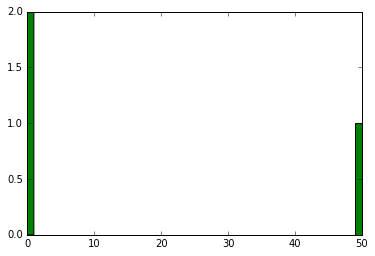

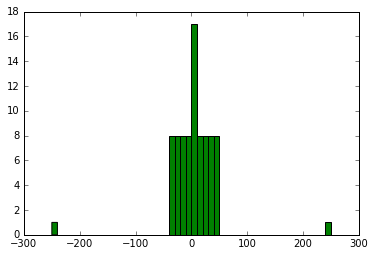

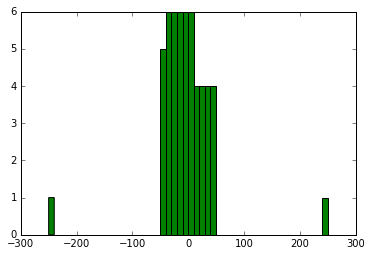

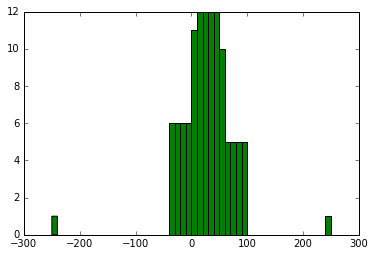

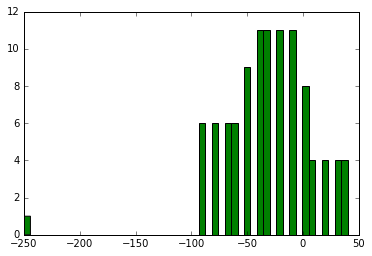

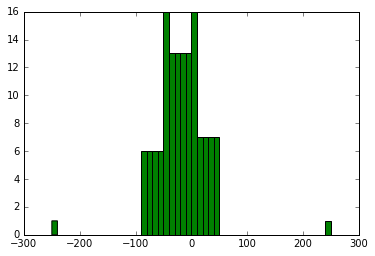

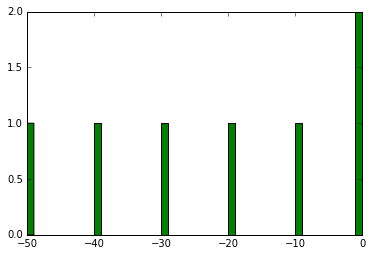

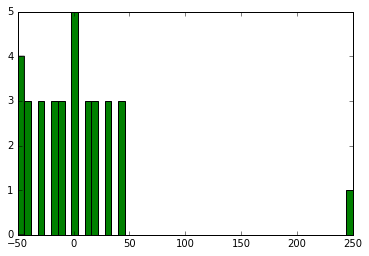

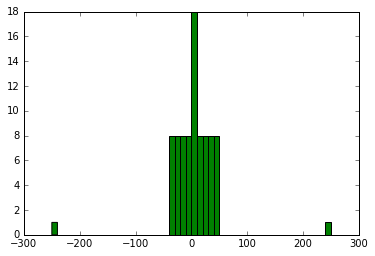

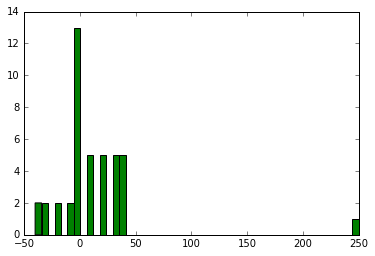

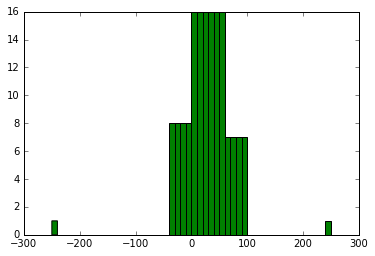

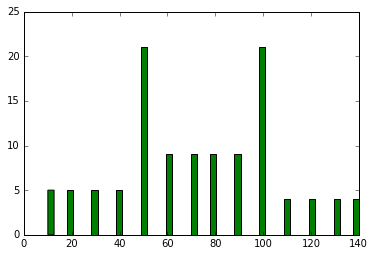

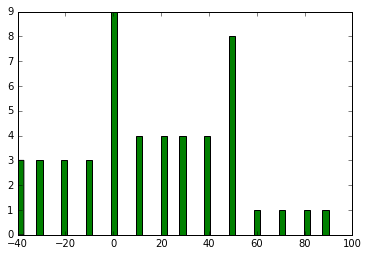

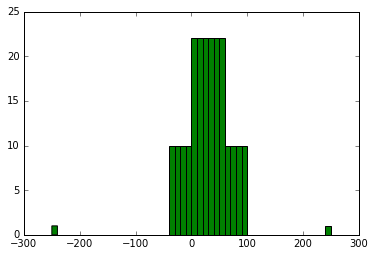

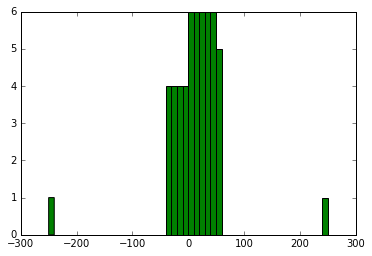

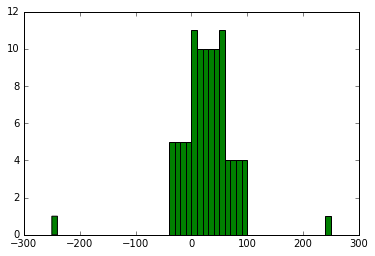

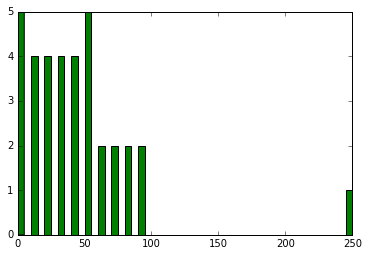

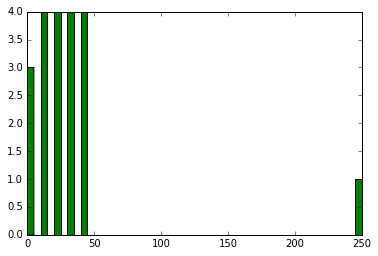

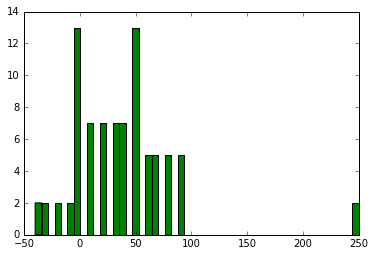

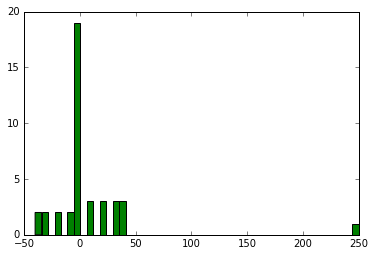

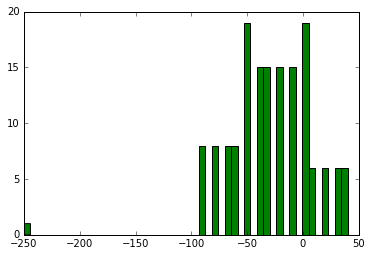

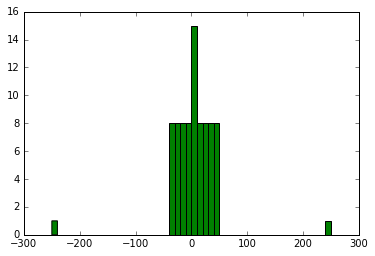

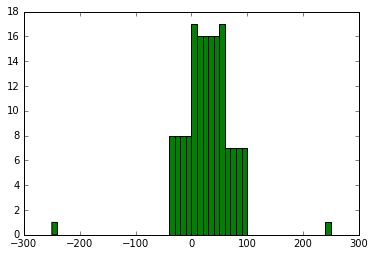

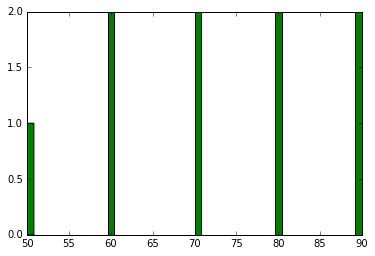

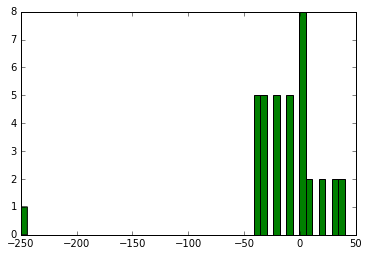

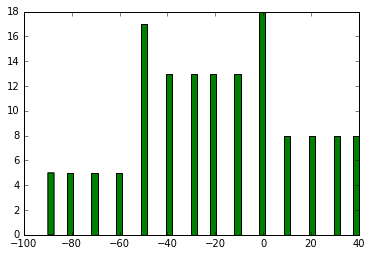

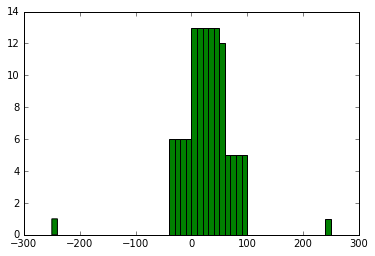

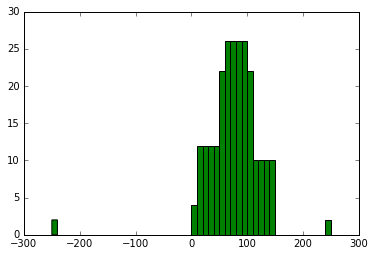

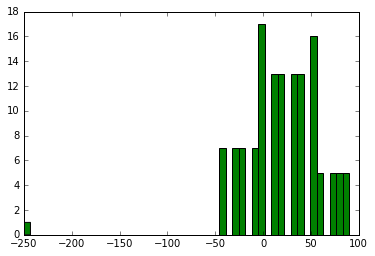

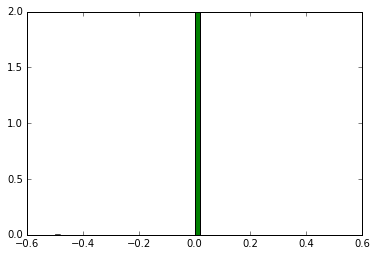

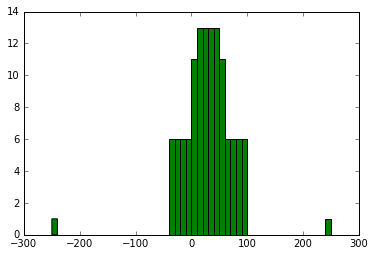

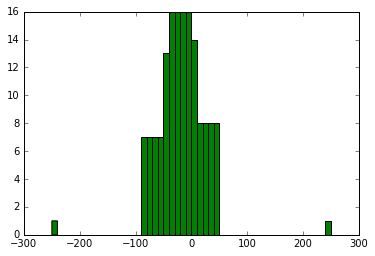

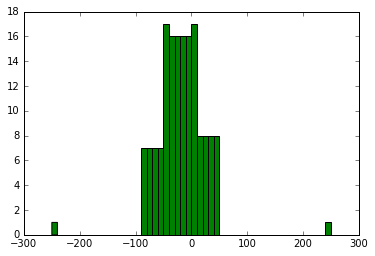

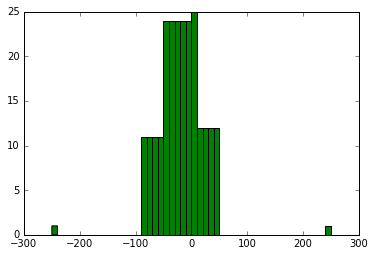

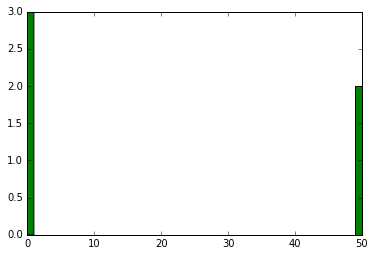

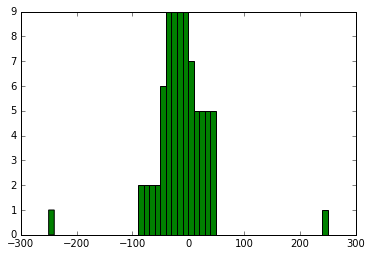

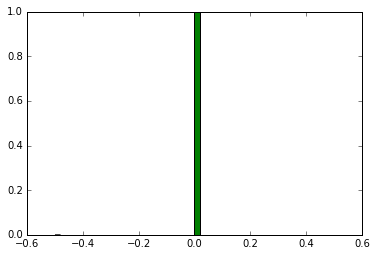

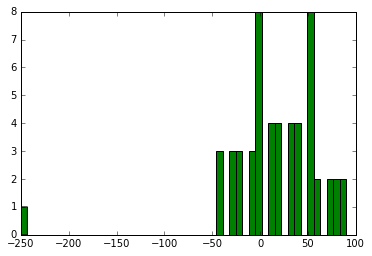

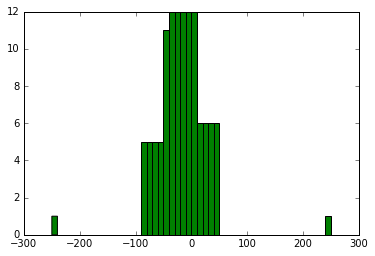

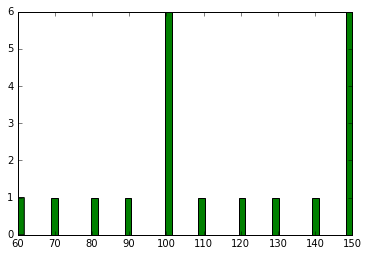

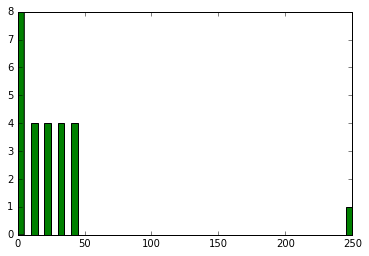

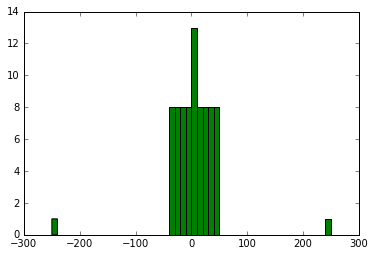

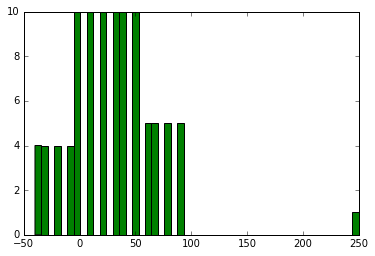

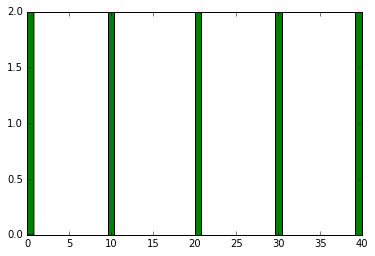

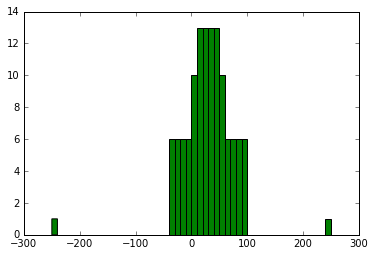

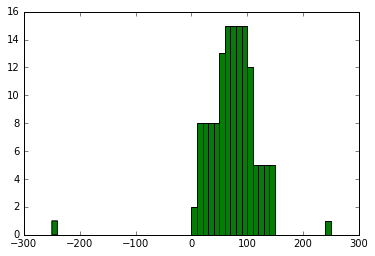

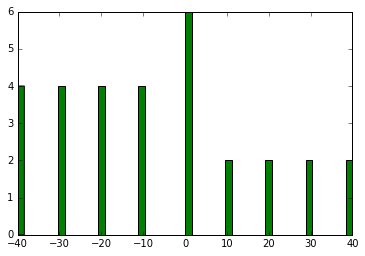

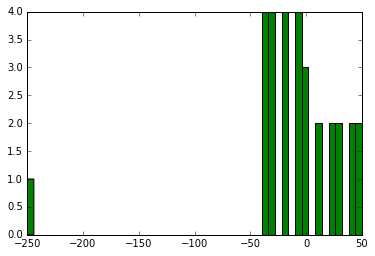

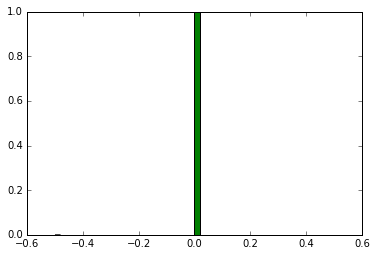

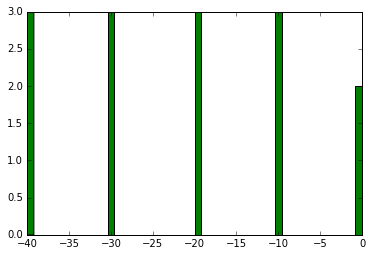

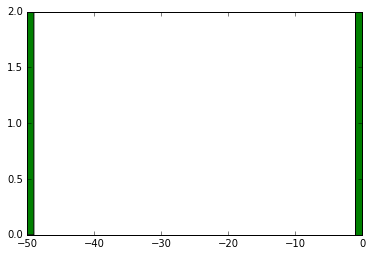

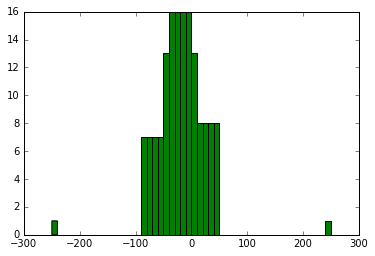

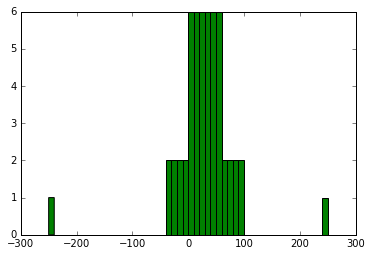

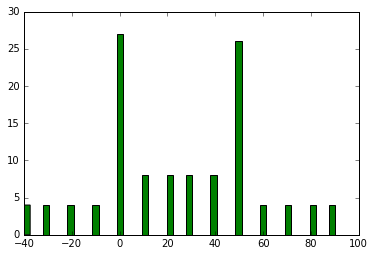

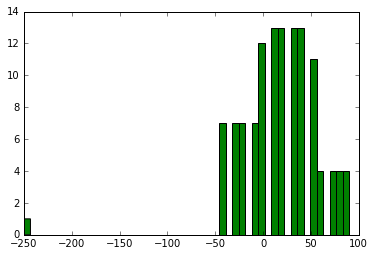

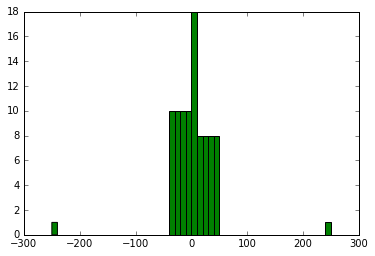

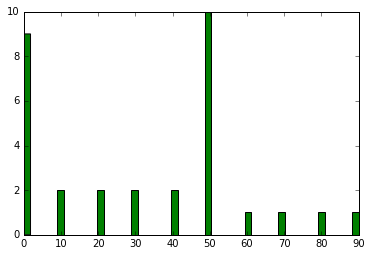

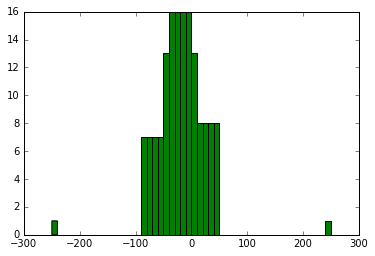

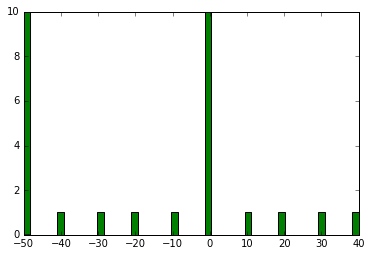

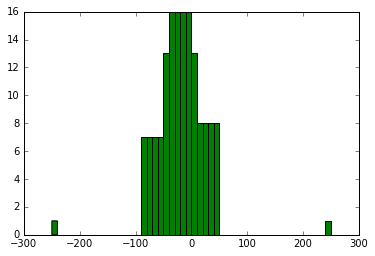

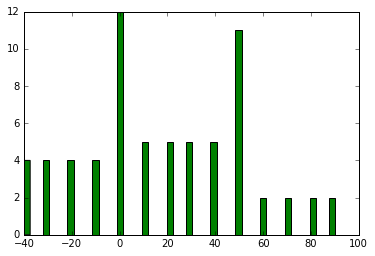

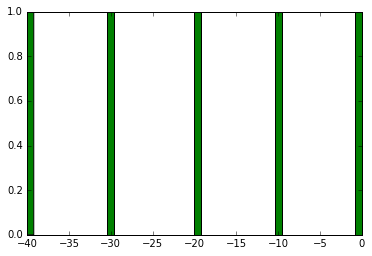

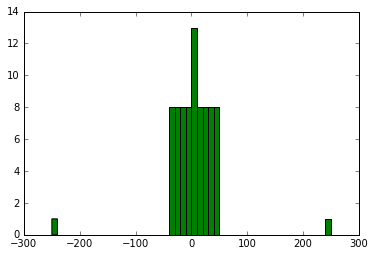

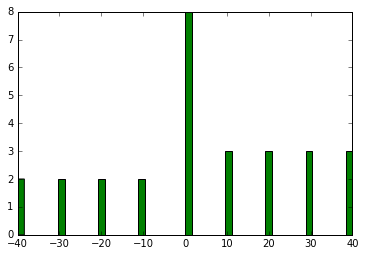

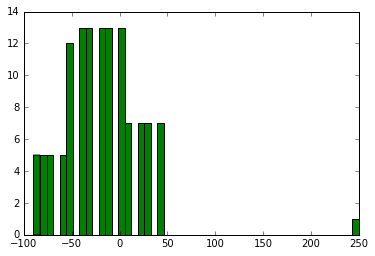

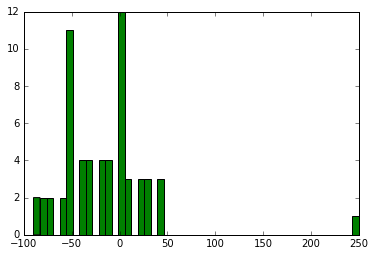

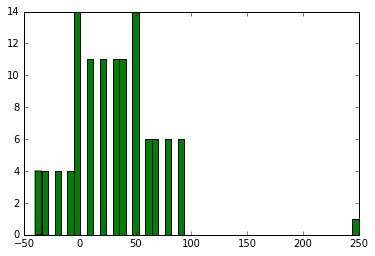

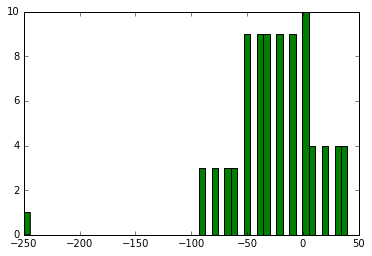

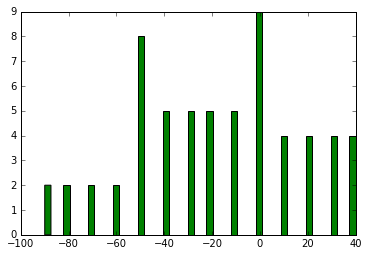

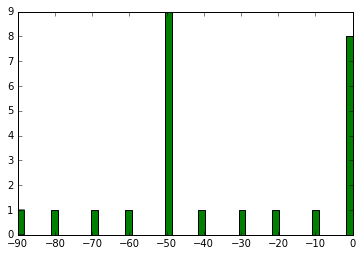

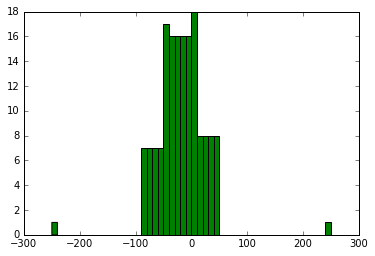

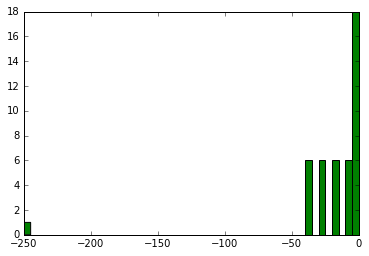

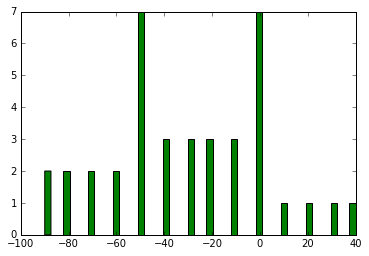

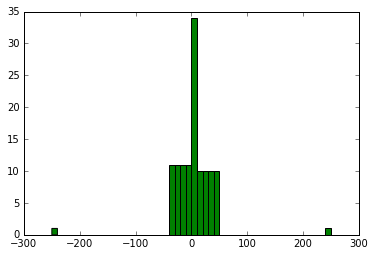

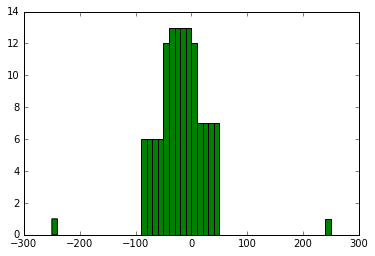

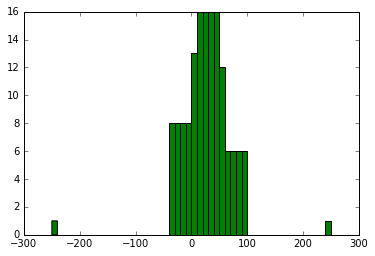

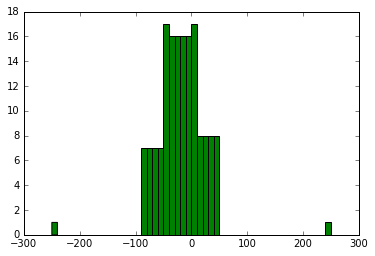

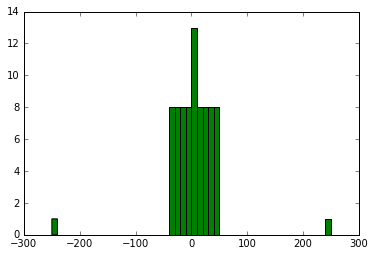

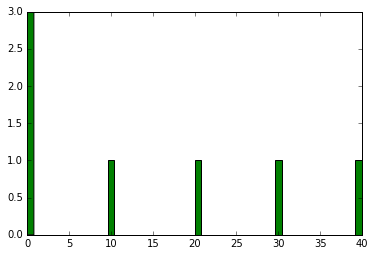

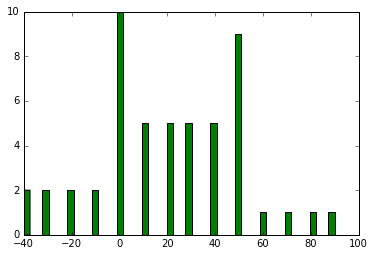

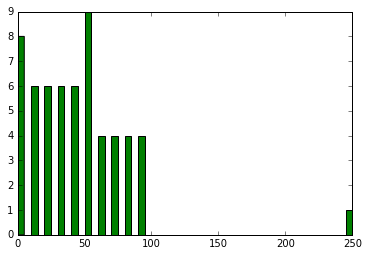

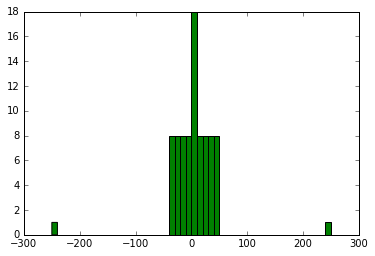

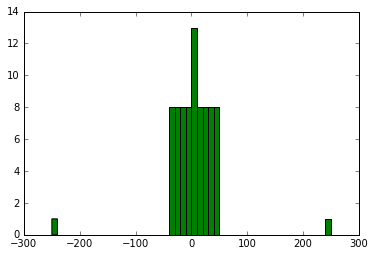

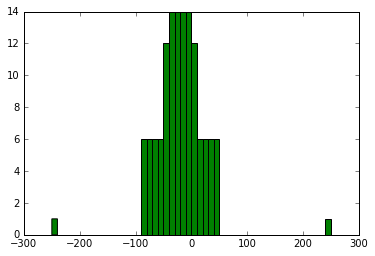

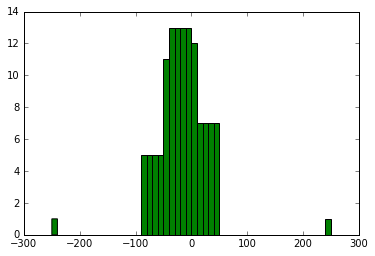

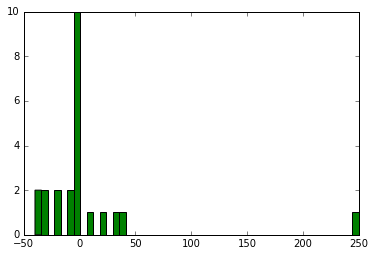

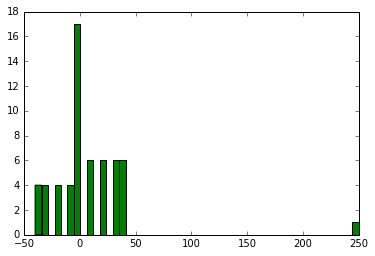

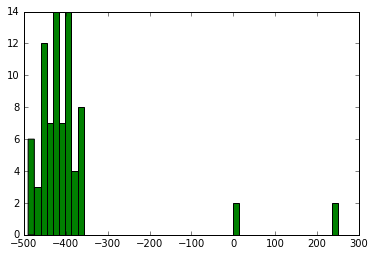

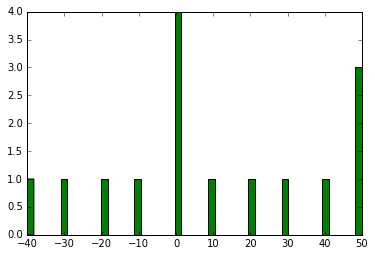

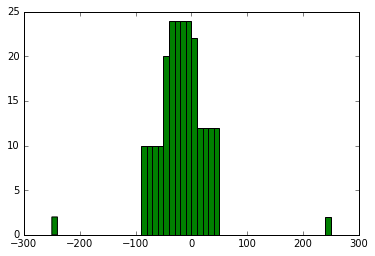

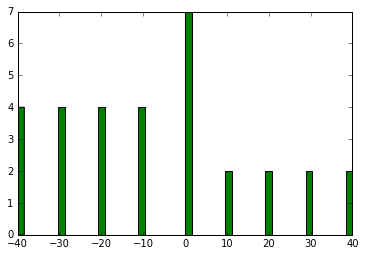

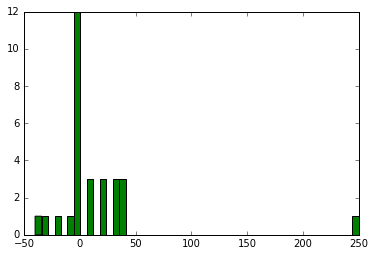

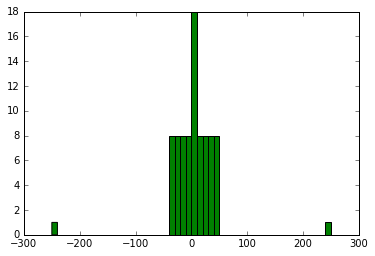

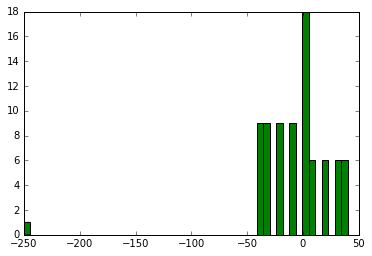

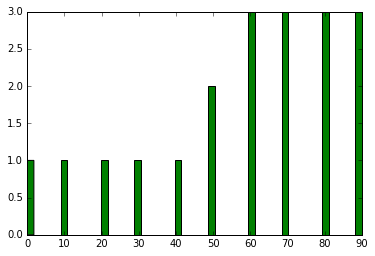

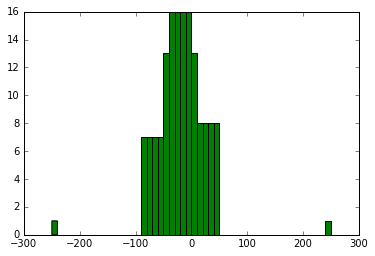

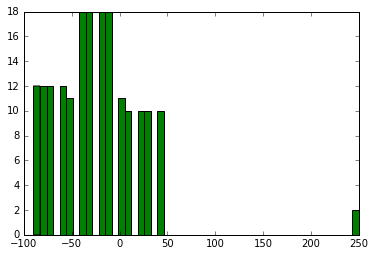

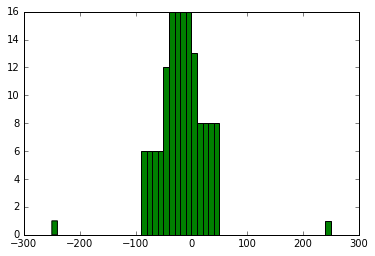

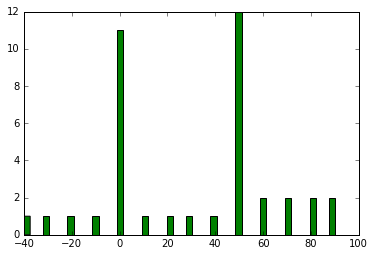

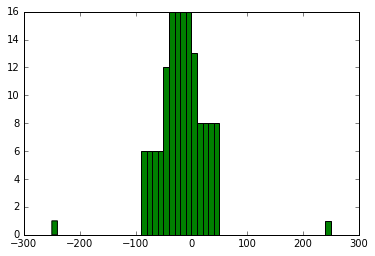

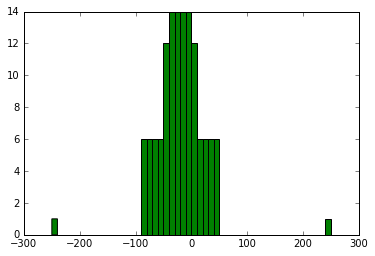

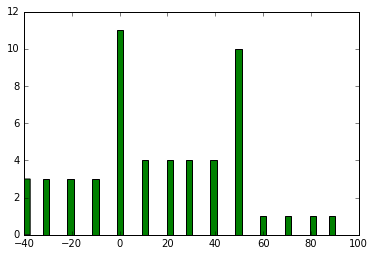

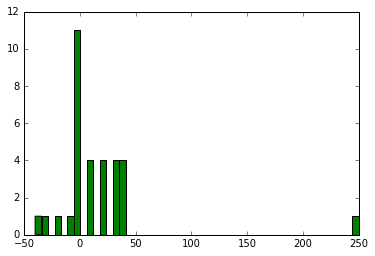

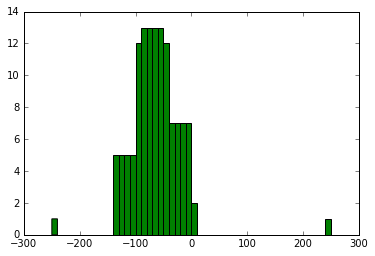

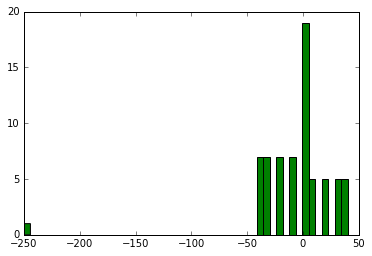

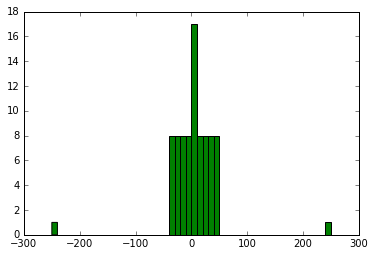

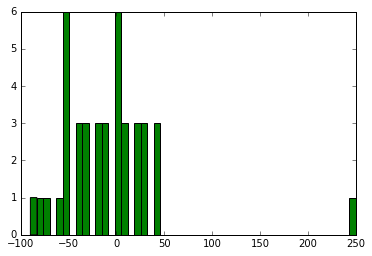

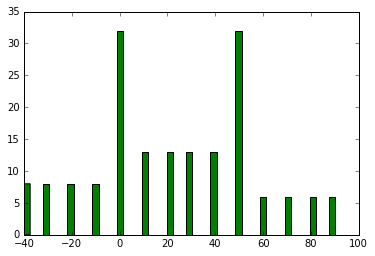

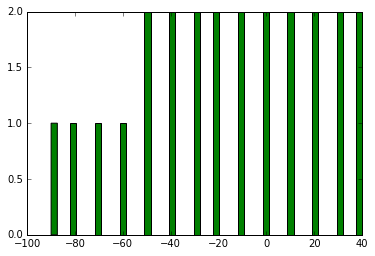

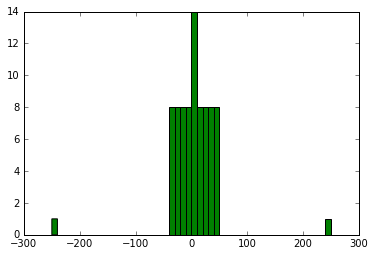

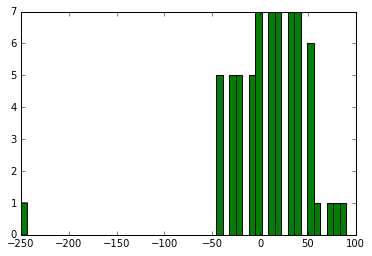

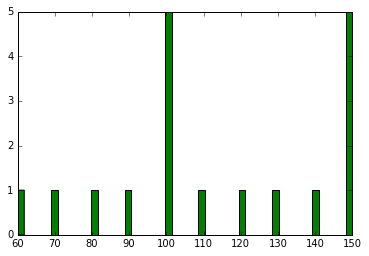

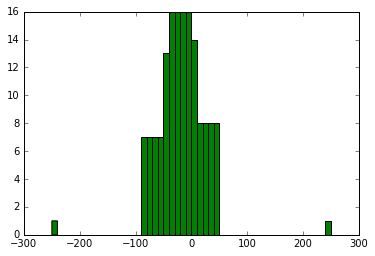

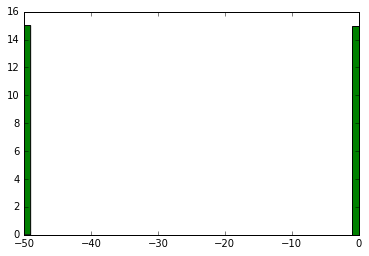

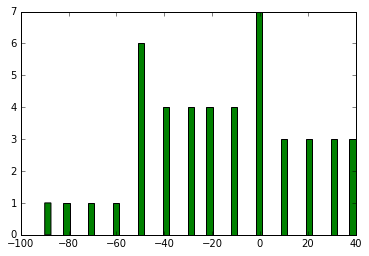

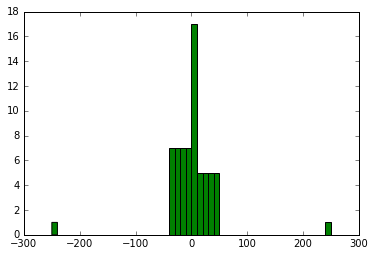

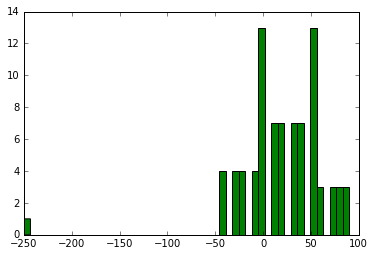

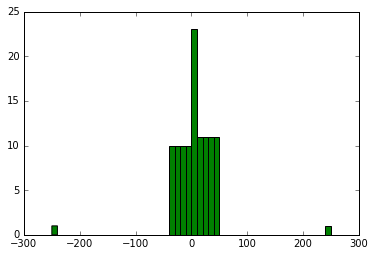

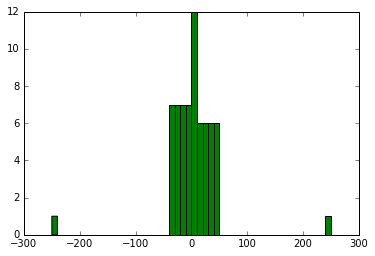

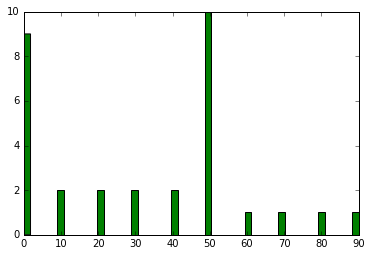

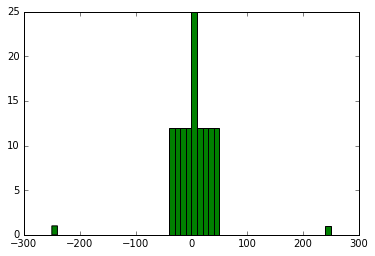

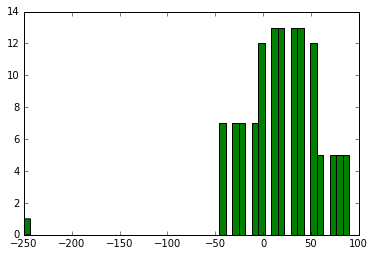

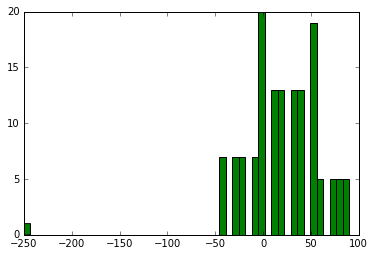

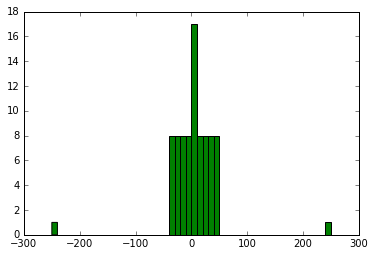

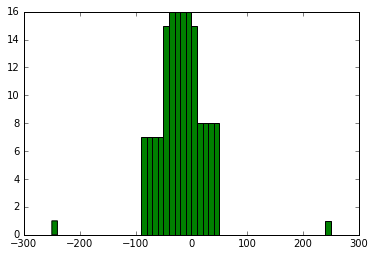

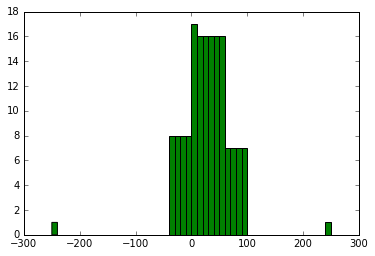

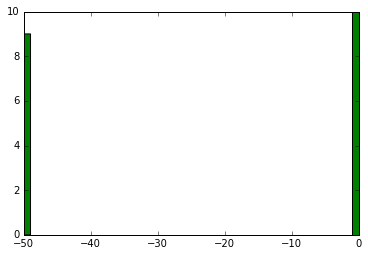

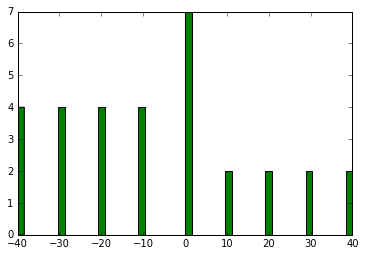

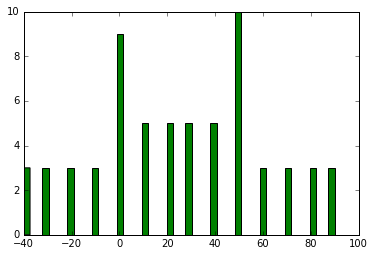

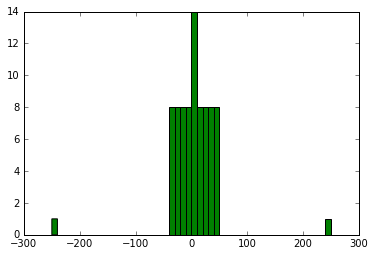

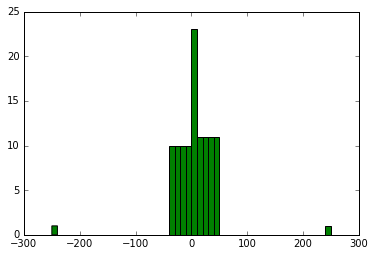

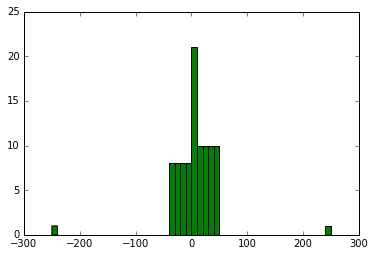

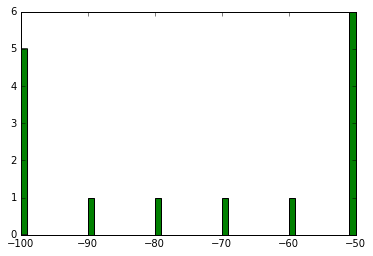

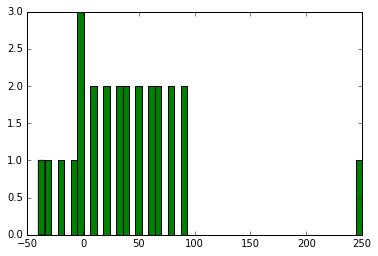

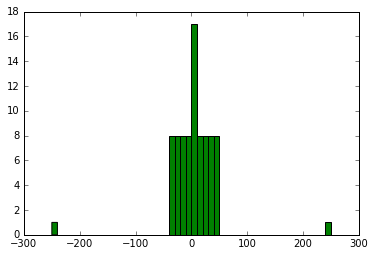

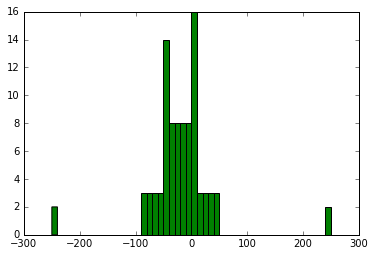

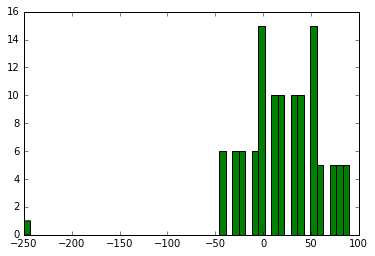

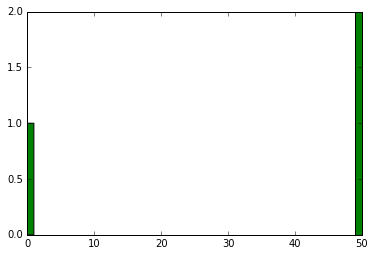

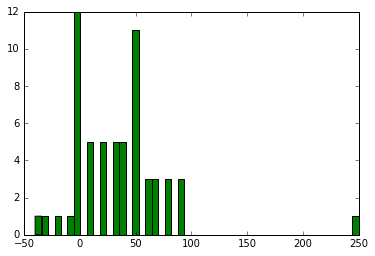

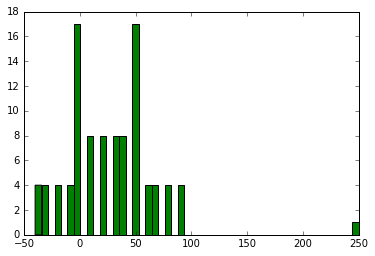

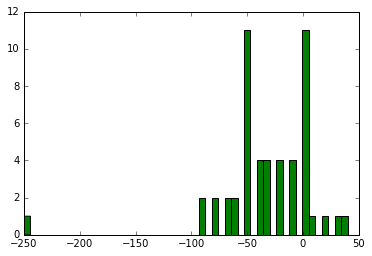

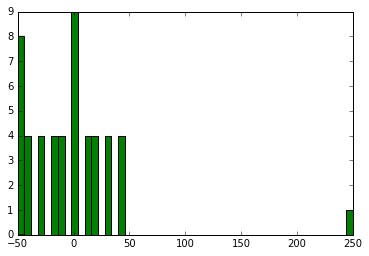

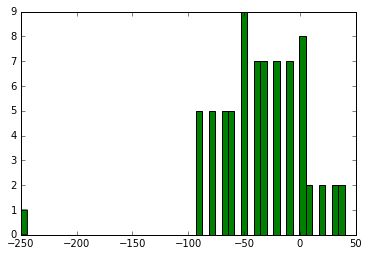

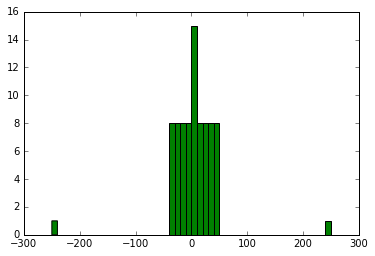

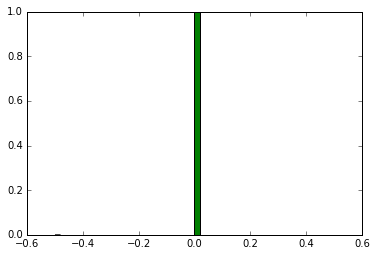

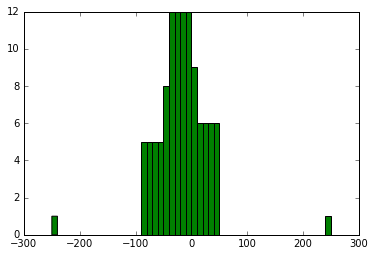

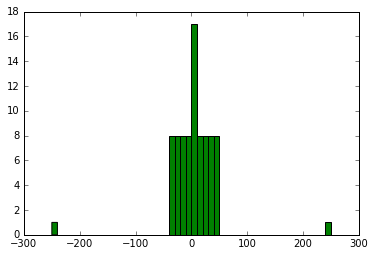

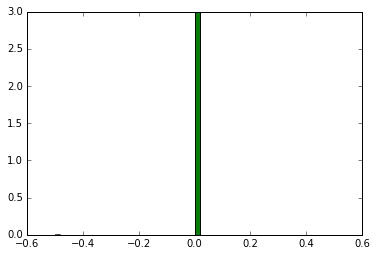

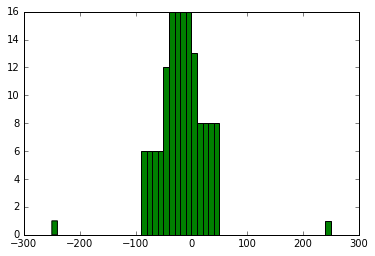

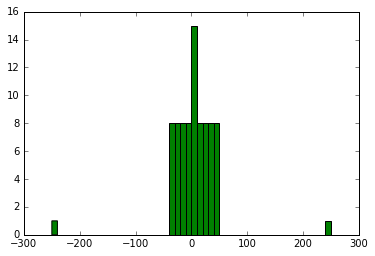

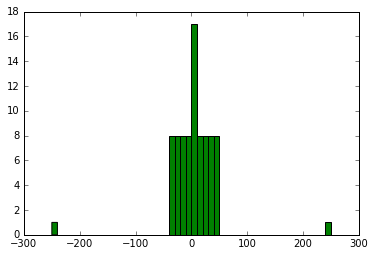

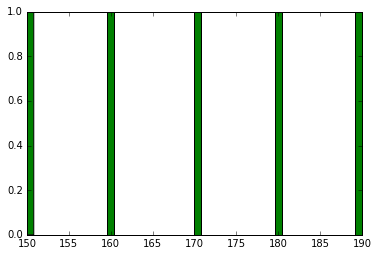

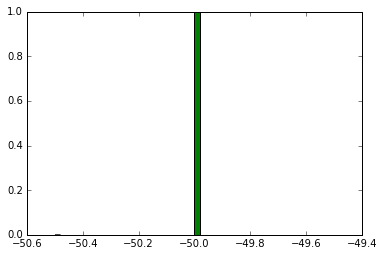

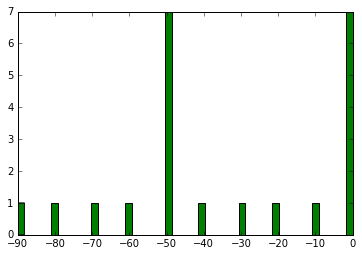

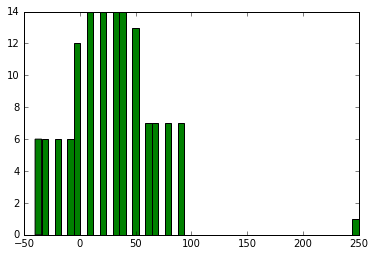

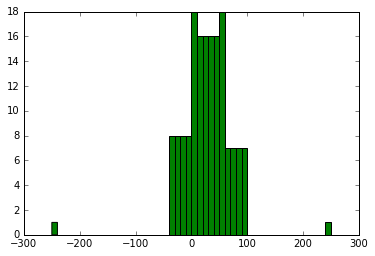

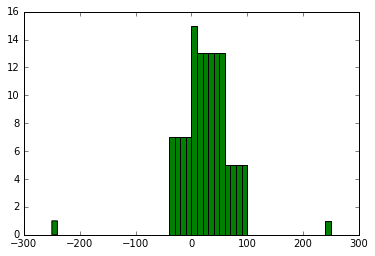

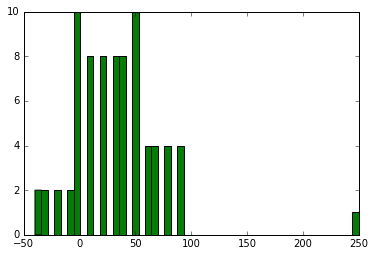

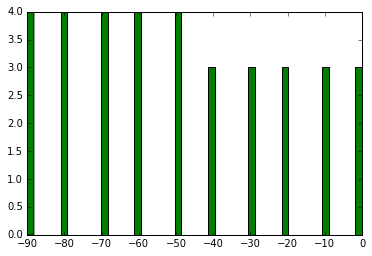

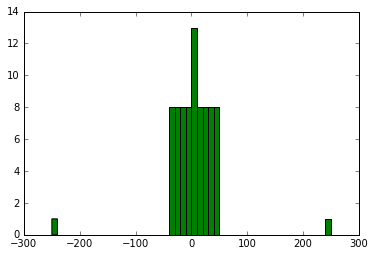

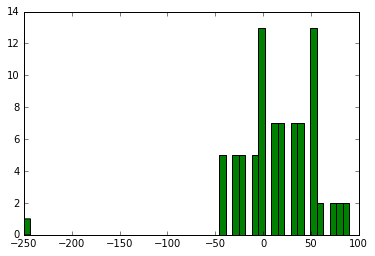

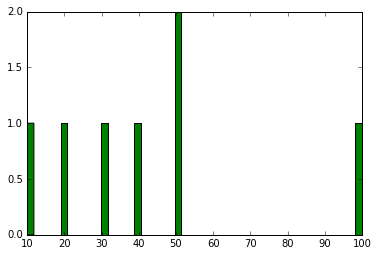

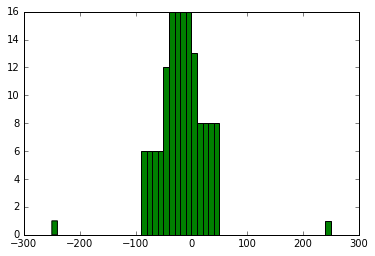

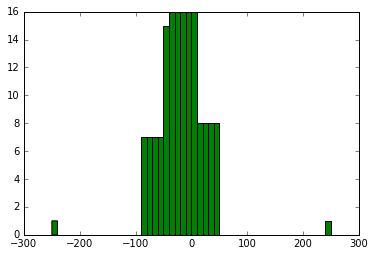

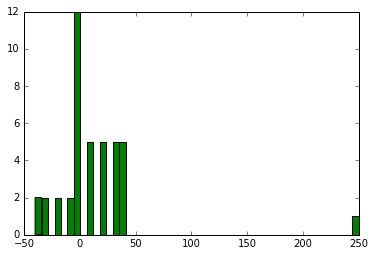

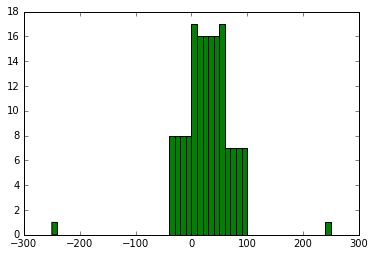

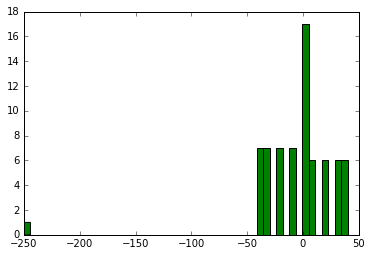

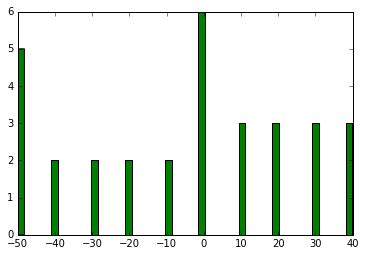

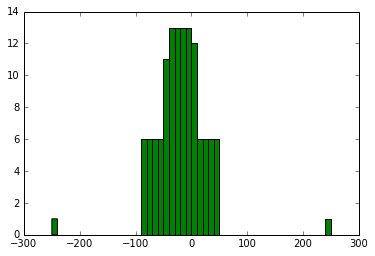

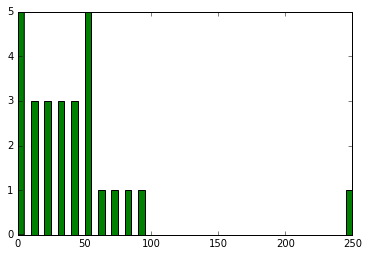

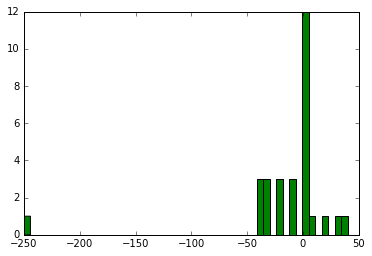

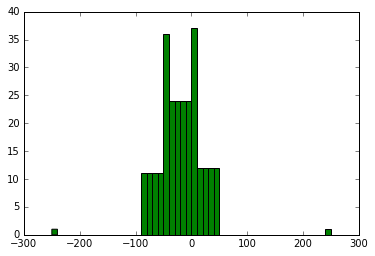

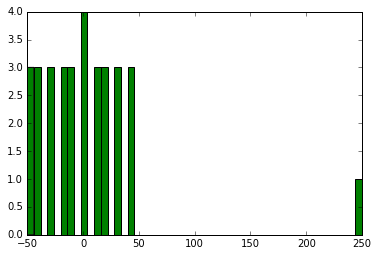

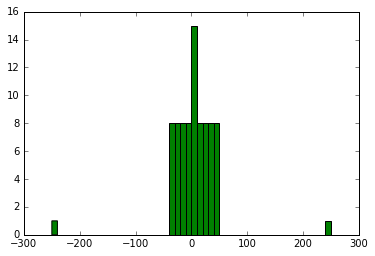

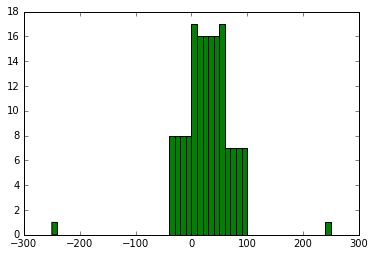

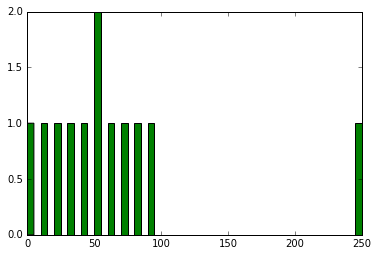

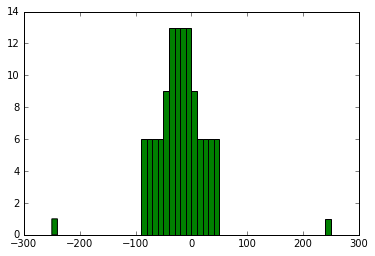

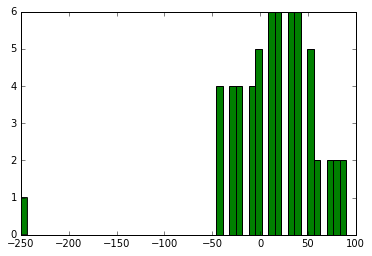

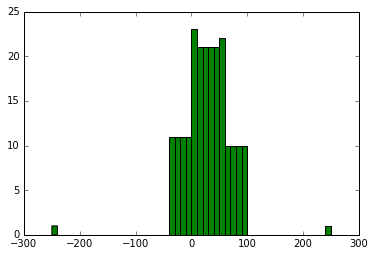

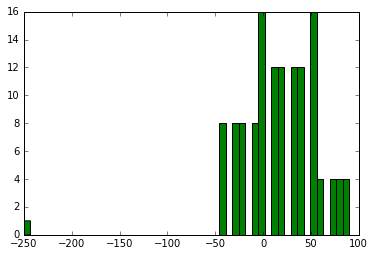

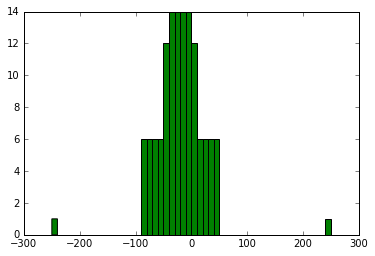

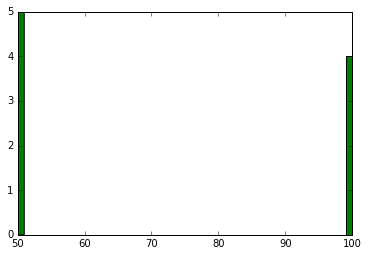

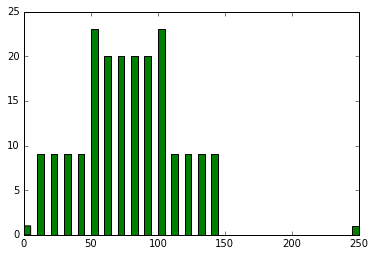

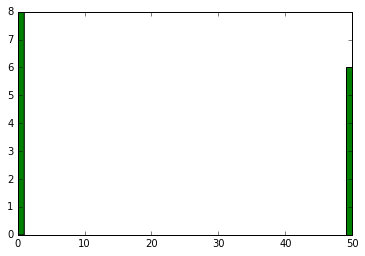

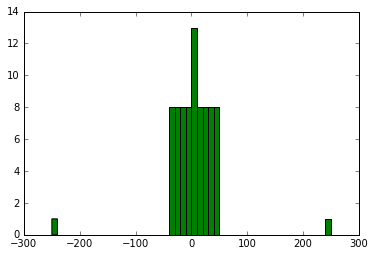

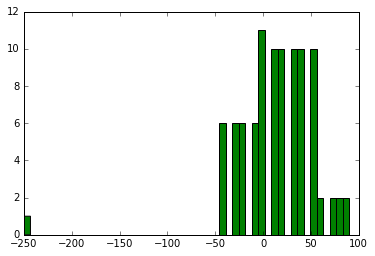

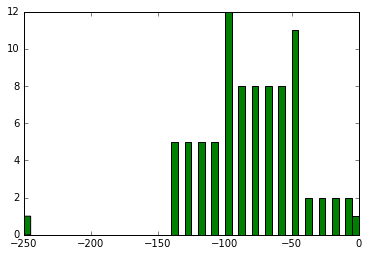

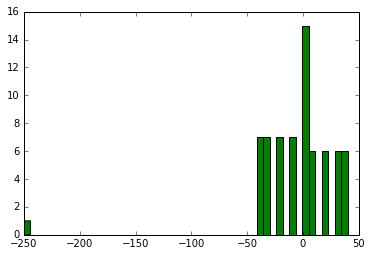

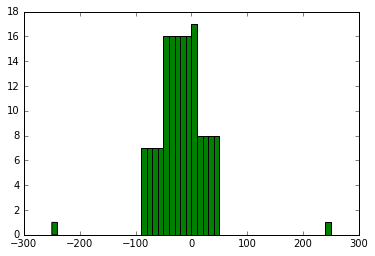

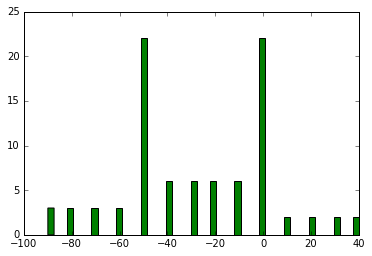

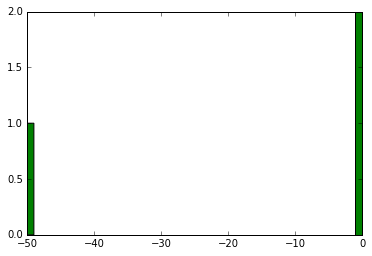

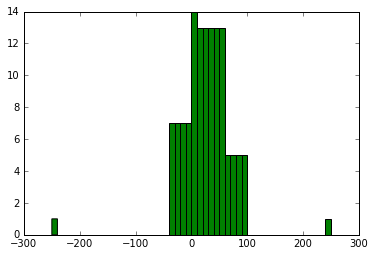

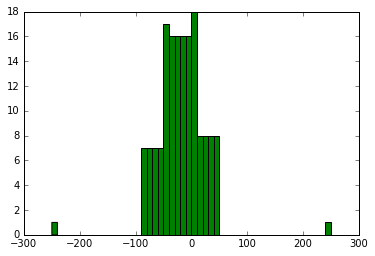

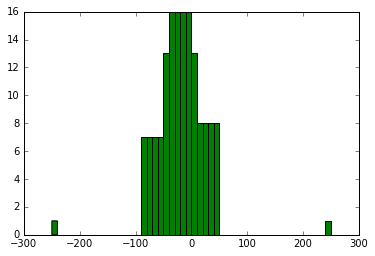

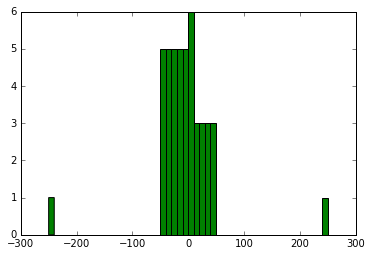

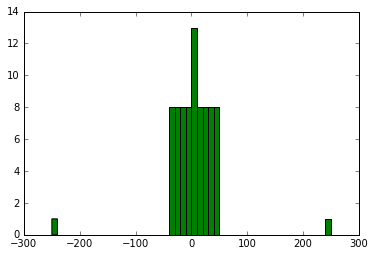

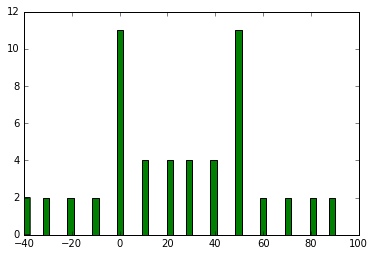

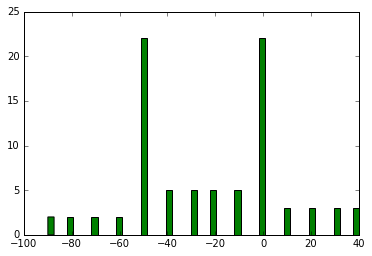

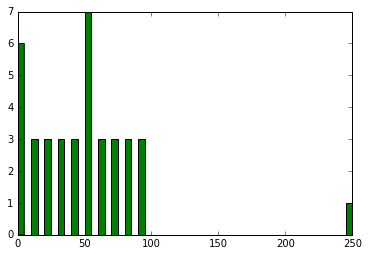

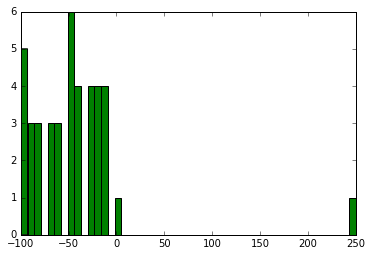

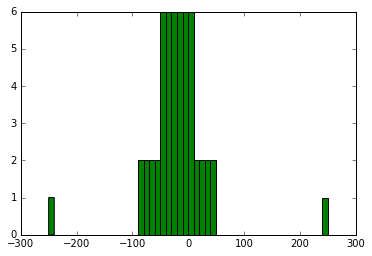

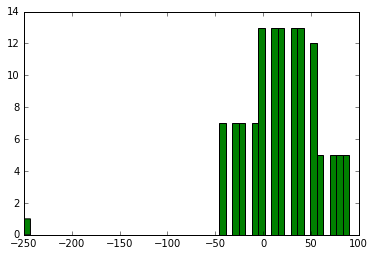

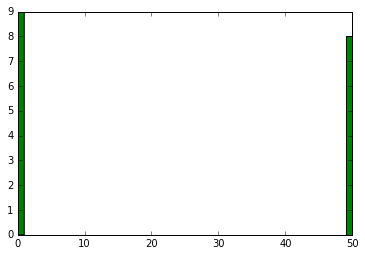

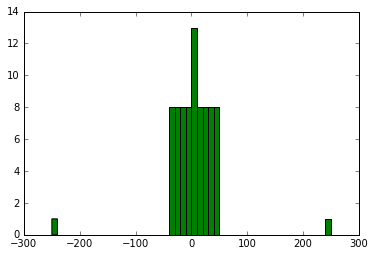

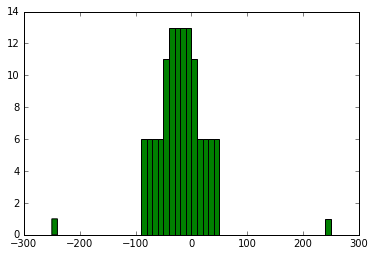

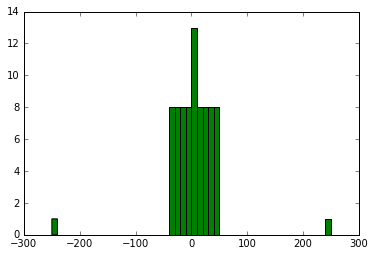

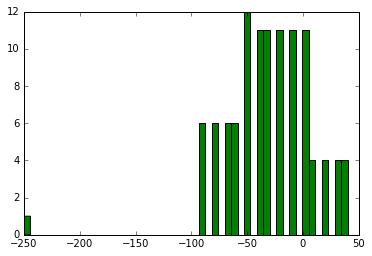

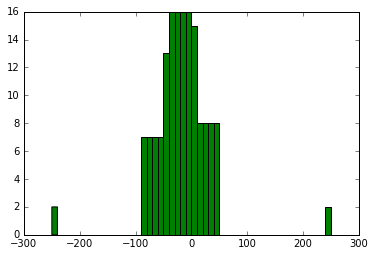

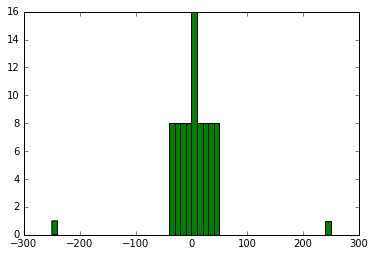

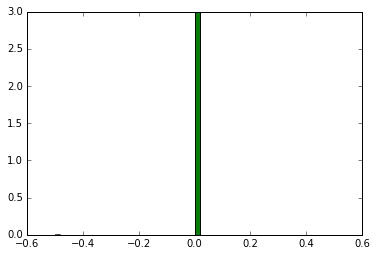

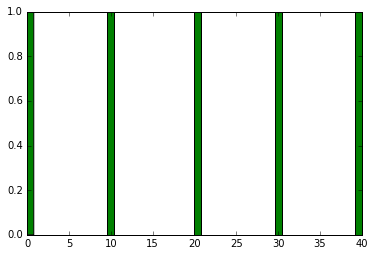

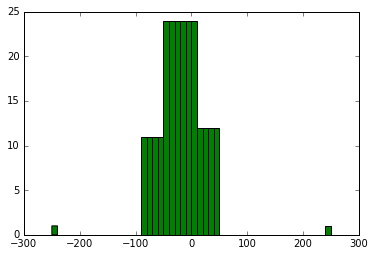

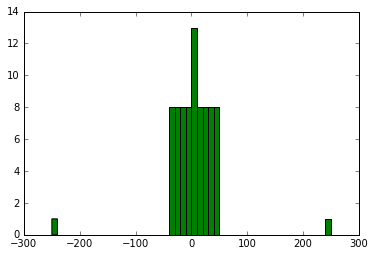

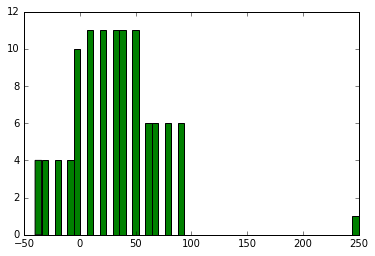

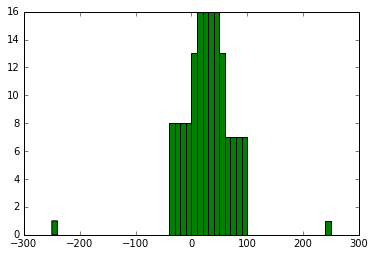

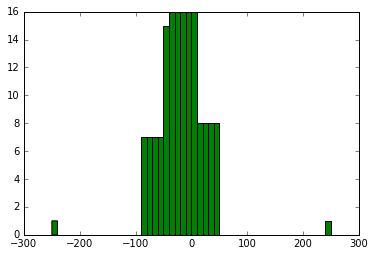

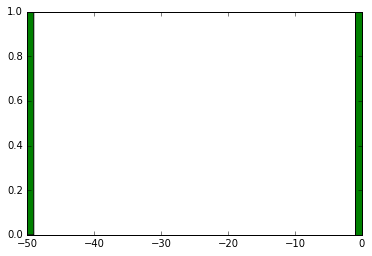

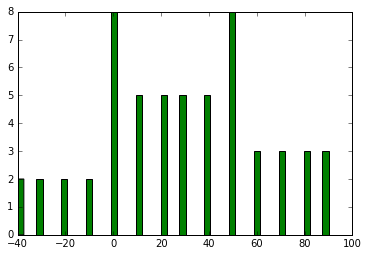

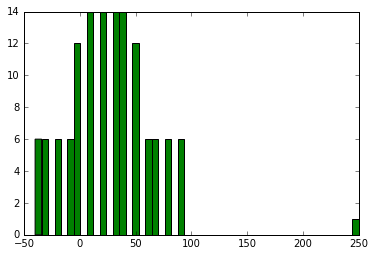

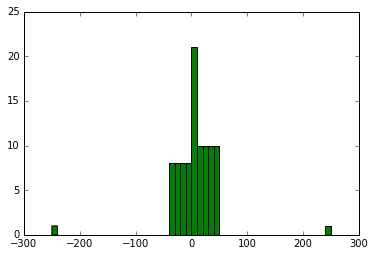

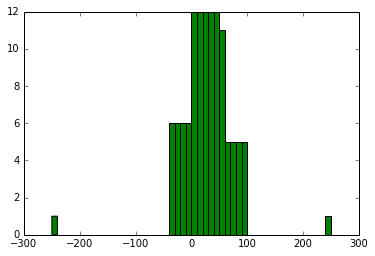

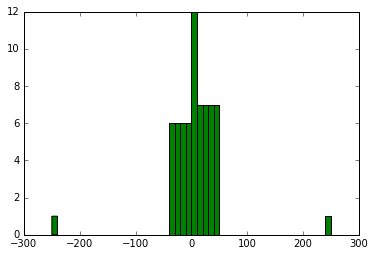

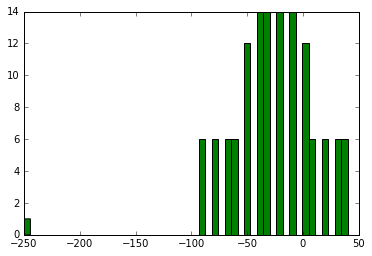

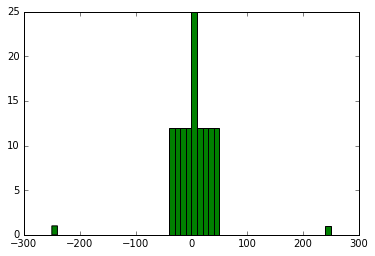

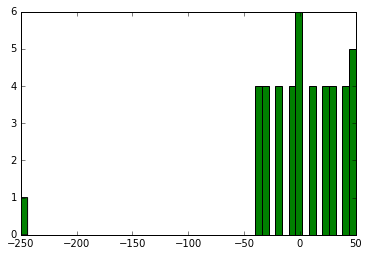

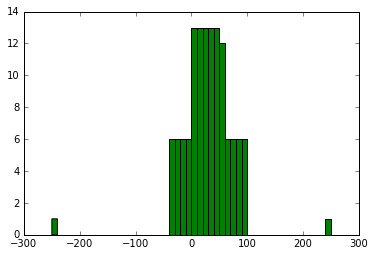

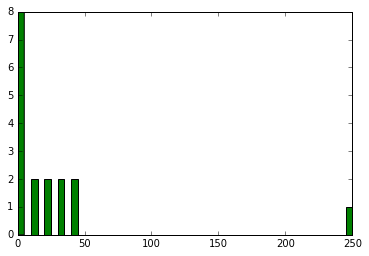

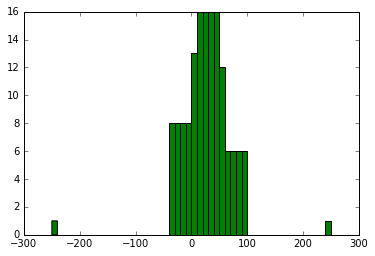

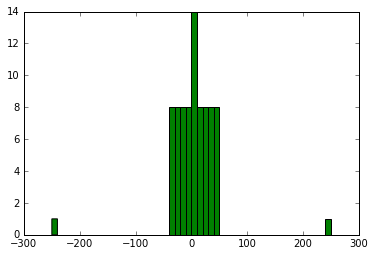

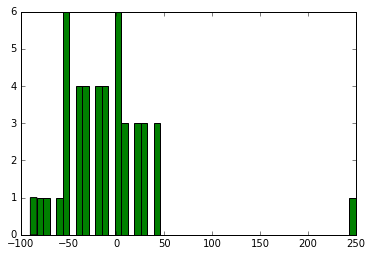

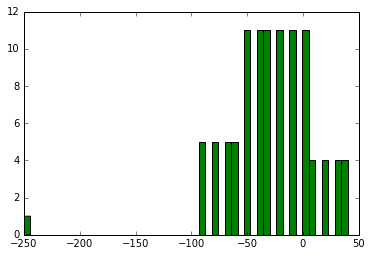

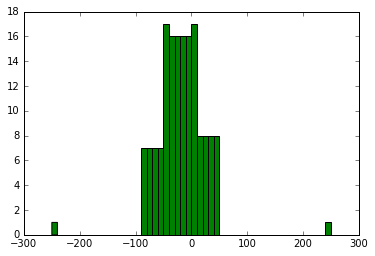

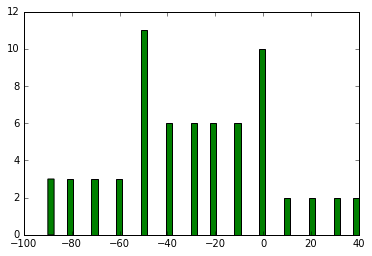

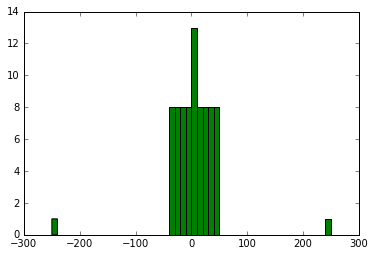

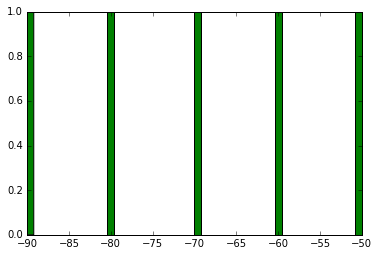

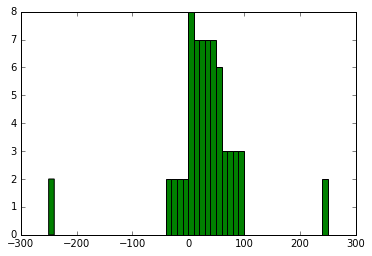

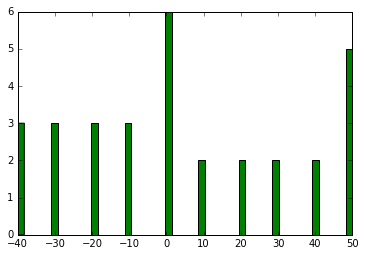

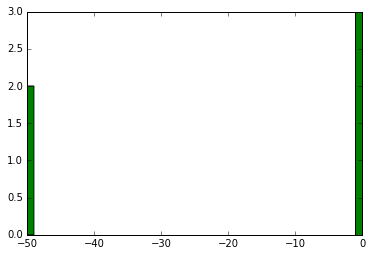

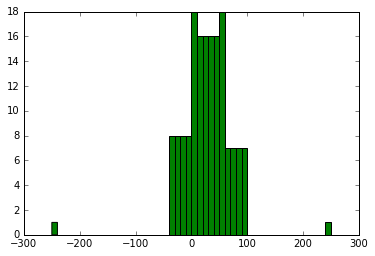

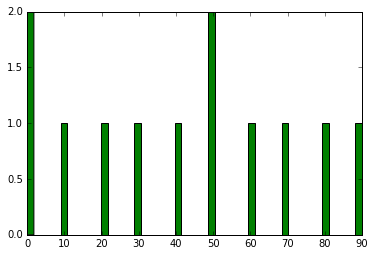

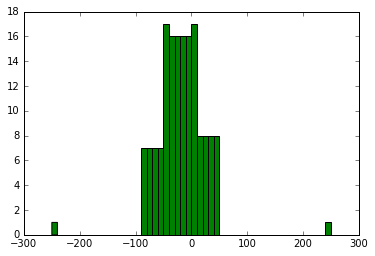

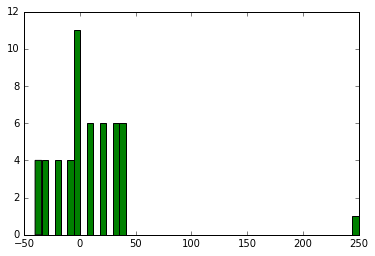

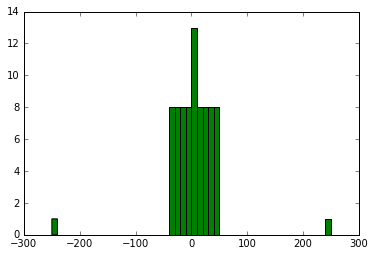

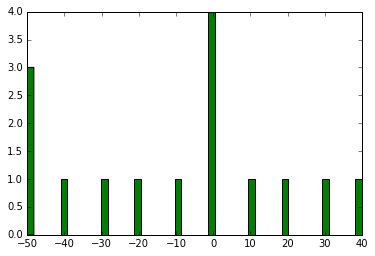

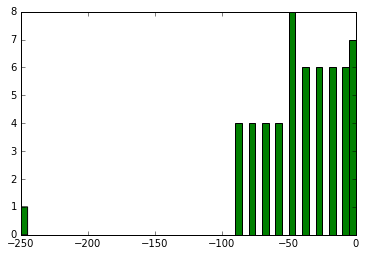

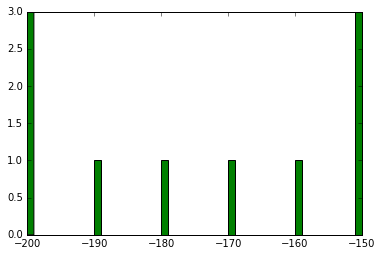

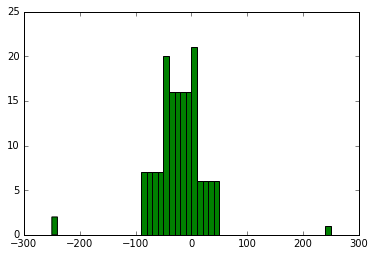

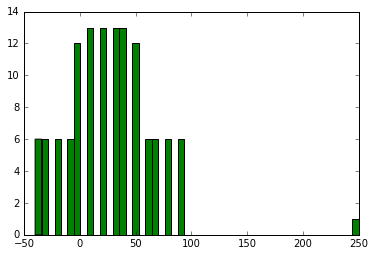

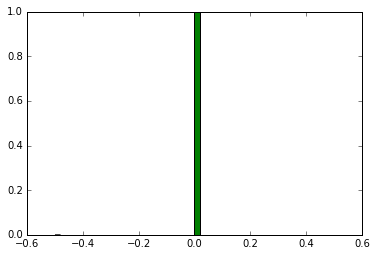

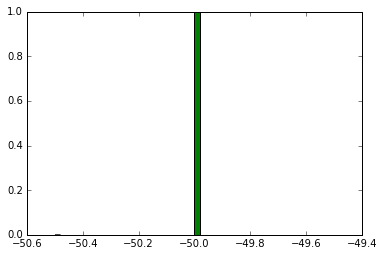

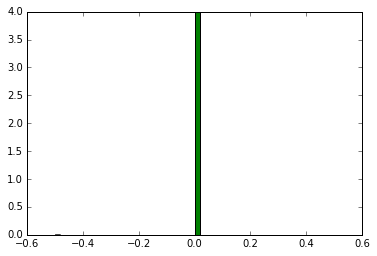

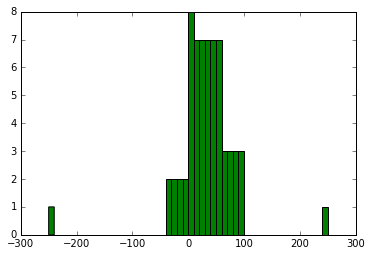

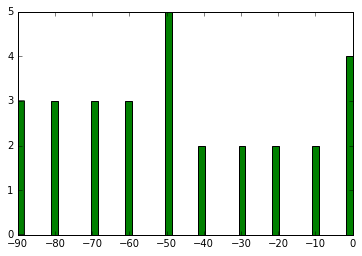

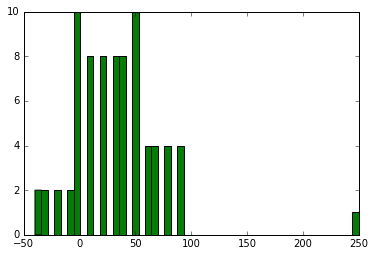

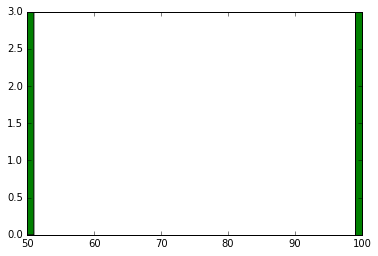

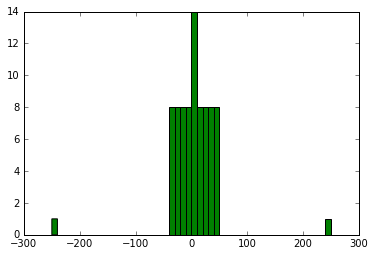

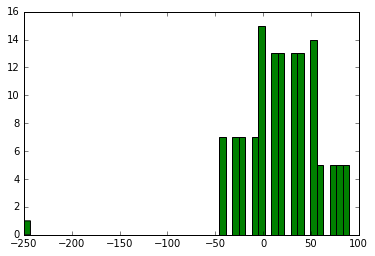

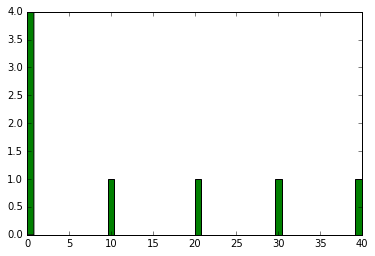

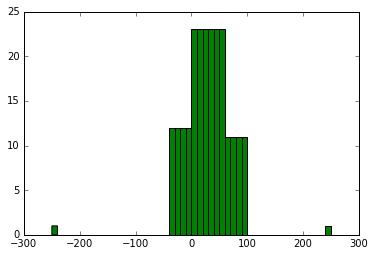

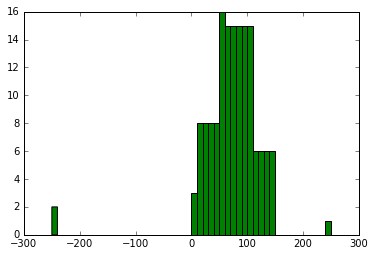

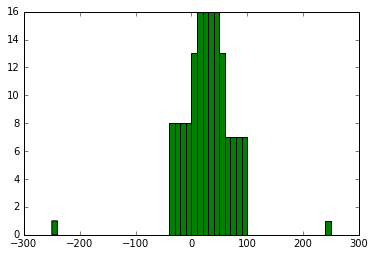

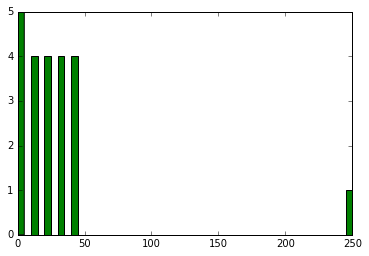

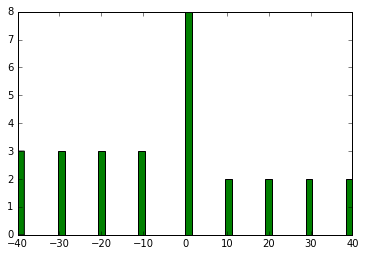

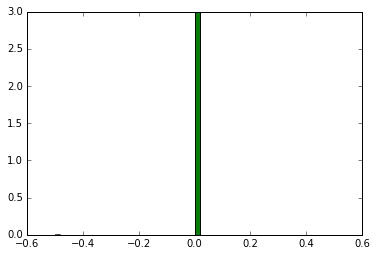

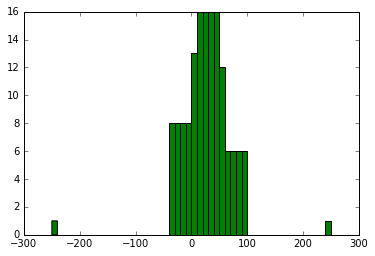

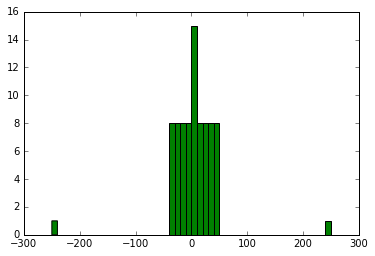

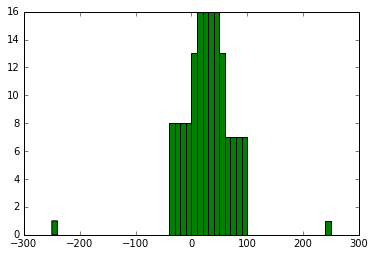

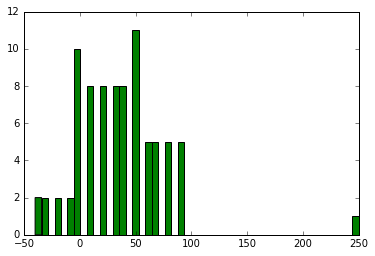

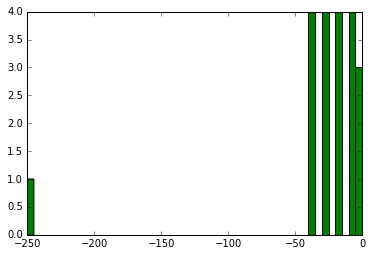

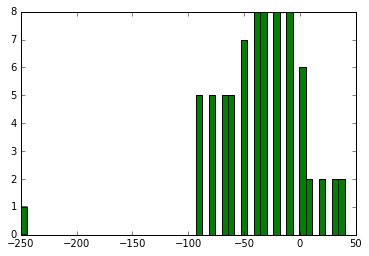

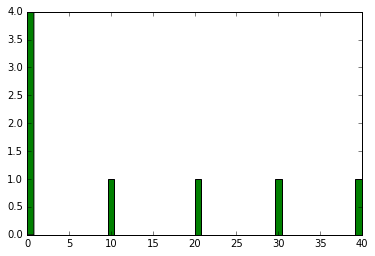

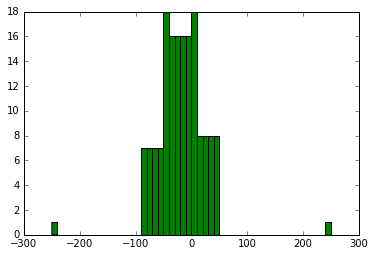

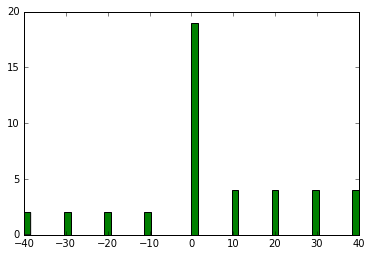

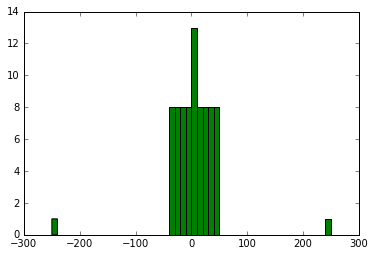

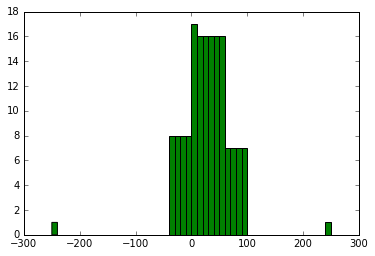

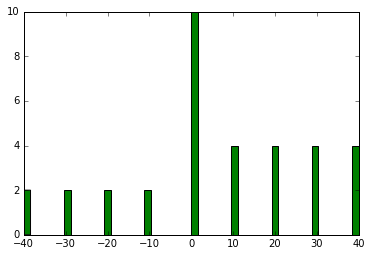

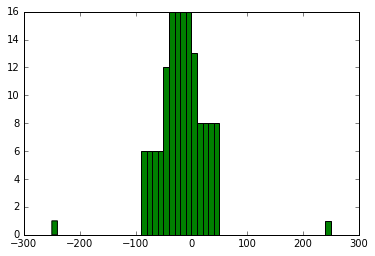

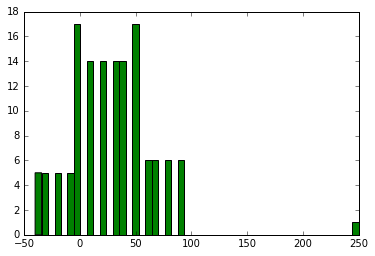

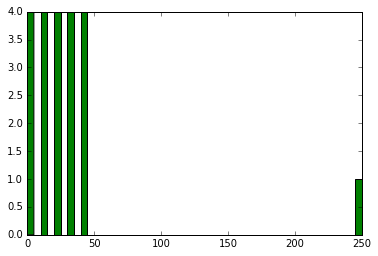

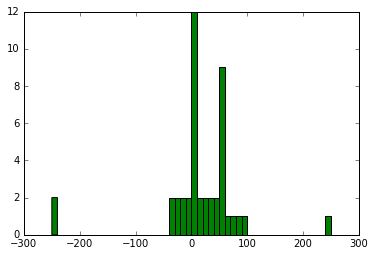

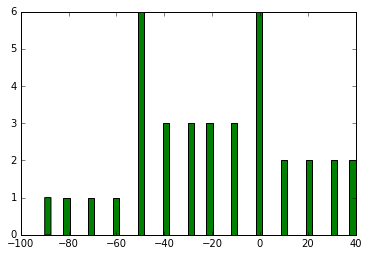

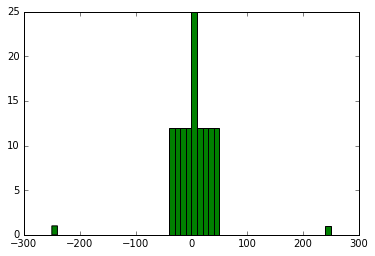

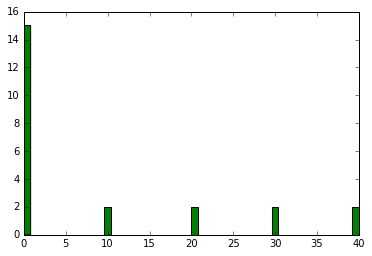

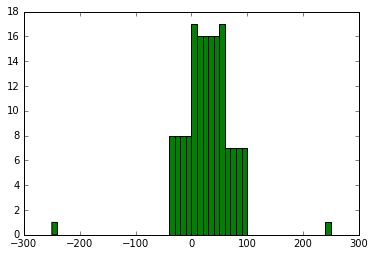

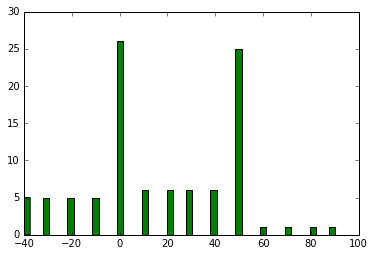

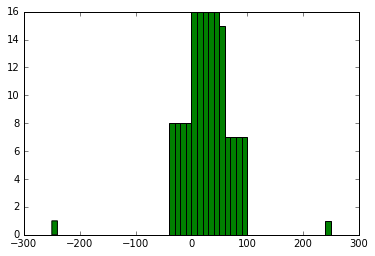

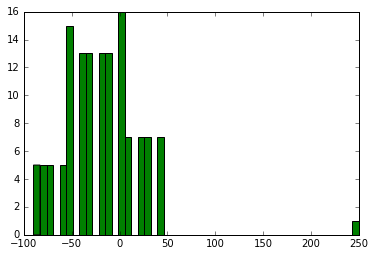

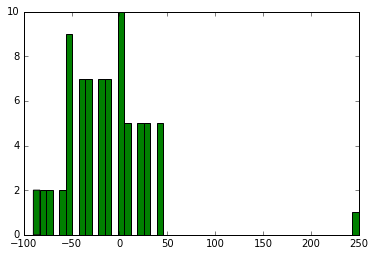

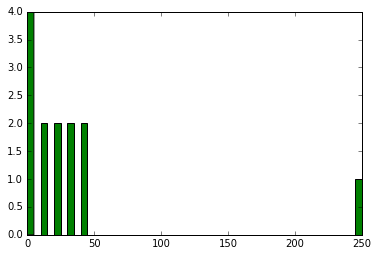

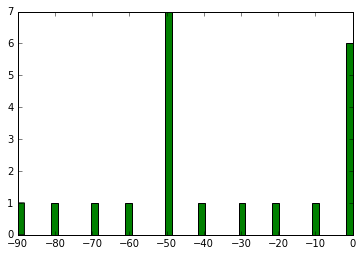

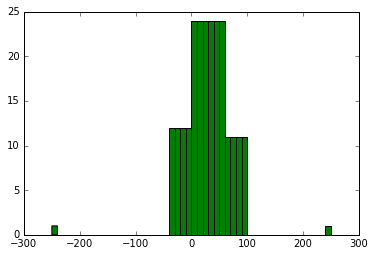

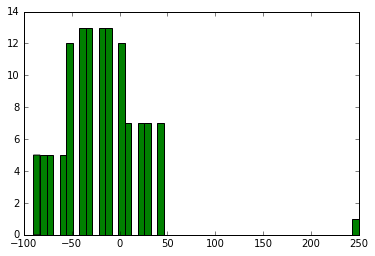

In [17]:
# OR RUN THIS: CREATE HISTOGRAM

all_matches = pd.read_csv('votes_cubes_match_synt.csv') #('real_cubes_all_vote.csv')
all_matches = all_matches[all_matches["class"] == 1]
for idx, row in all_matches.iterrows():
    draw_histogram_for_row(row, 50)
